In [1]:
%load_ext autoreload
%autoreload

In [2]:
%matplotlib inline 

import sys
import os
import math
import copy
from collections import OrderedDict, defaultdict

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import pymaster as nmt
import pyccl as ccl
from tqdm.notebook import tqdm
from scipy.integrate import simps

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH
from utils import get_config, get_normalized_dist, save_correlations, read_fits_to_pandas, read_correlations, get_jackknife_masks, get_config
from data_lotss import get_lotss_redshift_distribution, get_skads_sim_data, read_lotss_noise_weight_map, get_lotss_data, get_lotss_map, get_lotss_redshift_distribution, get_biggest_optical_region, get_redshift_distributions, LOTSS_JACKKNIFE_REGIONS
from experiment import Experiment
from reports import show_mcmc_report
from plotting import my_mollview, plot_correlation_matrix, plot_correlation, plot_many_data_correlations, plot_correlation_comparison, plot_jackknife_regions
from redshift import plot_redshift_distributions, get_powerlaw_redshift, make_tomographer_fit

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style='ticks')
pd.set_option('mode.chained_assignment', None)

In [4]:
data_name = 'LoTSS_DR2'

# Run correlations

In [5]:
config = get_config(data_name)
display(config)

In [6]:
experiment = Experiment(config, set_data=True, set_maps=True)

07/04/2022 14:23:08 INFO: Setting data..


Original LoTSS DR2 datashape: (4395448, 24)


07/04/2022 14:23:10 INFO: Setting maps..
07/04/2022 14:23:10 INFO: NSIDE = 512
07/04/2022 14:23:10 INFO: ORDERING = RING in fits file
07/04/2022 14:23:10 INFO: INDXSCHM = IMPLICIT


Total flux of S > 1.5 mJy: (1401038, 24)
Signal to noise > 7.5: (1025122, 24)


07/04/2022 14:23:10 INFO: NSIDE = 512
07/04/2022 14:23:10 INFO: ORDERING = RING in fits file
07/04/2022 14:23:10 INFO: INDXSCHM = IMPLICIT
07/04/2022 14:23:10 INFO: NSIDE = 512
07/04/2022 14:23:10 INFO: ORDERING = RING in fits file
07/04/2022 14:23:10 INFO: INDXSCHM = IMPLICIT
07/04/2022 14:23:19 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
07/04/2022 14:23:19 INFO: -> fwhm is 0.000000 arcmin
07/04/2022 14:23:19 INFO: NSIDE = 2048
07/04/2022 14:23:19 INFO: ORDERING = RING in fits file
07/04/2022 14:23:19 INFO: INDXSCHM = IMPLICIT


In [7]:
experiment.set_correlations(with_covariance=True)

07/04/2022 14:23:45 INFO: Setting data correlations..
07/04/2022 14:23:54 INFO: Setting theory correlations..
07/04/2022 14:23:55 INFO: Setting covariance..


In [ ]:
save_correlations(experiment)

In [16]:
# Save data
experiment.data['g'][['RA', 'DEC']].to_csv(os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer/LoTSS_DR2_v100.srl_1.5mJy_7.5SNR.csv'))

In [8]:
# Save mask
r = hp.Rotator(coord=['C', 'G'])
tmp = experiment.masks['g'].filled(0)
tmp = r.rotate_map_pixel(tmp)
cfg = experiment.config
filename = 'mask_weight_{}mJy_{}SNR_inner_galactic_nside={}.fits'.format(cfg.flux_min_cut, cfg.signal_to_noise, cfg.nside)
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer', filename)
hp.fitsfunc.write_map(filepath, tmp, overwrite=True)
print('Mask saved to: {}'.format(filepath))

02/03/2022 14:57:27 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/mask_weight_1.5mJy_7.5SNR_inner_galactic_nside=512.fits


In [18]:
# Save map
r = hp.Rotator(coord=['C', 'G'])
tmp = experiment.processed_maps['g'].filled(0)
tmp = r.rotate_map_pixel(tmp)
cfg = experiment.config
filename = 'map_overdensity_{}mJy_{}SNR_inner_galactic_nside={}.fits'.format(cfg.flux_min_cut, cfg.signal_to_noise, cfg.nside)
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer', filename)
hp.fitsfunc.write_map(filepath, tmp, overwrite=True)
print('Map saved to: {}'.format(filepath))

02/03/2022 15:32:38 WARNING: setting the output map dtype to [dtype('float64')]


Map saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/map_overdensity_1.5mJy_7.5SNR_inner_galactic_nside=512.fits


In [11]:
# Save masks
from data_lotss import get_dr2_optical_region, get_lotss_dr2_mask

for nside in [256, 512, 1024, 2048]:
    # mask = get_dr2_optical_region(nside)
    mask = get_lotss_dr2_mask(nside, filename=None)

    r = hp.Rotator(coord=['C', 'G'])
    tmp = r.rotate_map_pixel(mask)

    filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer', 'mask_inner_galactic_nside={}.fits'.format(nside))
    hp.fitsfunc.write_map(filepath, tmp, overwrite=True)
    print('Mask saved to: {}'.format(filepath))

100%|████████████████████████████████████████████████████| 786432/786432 [00:05<00:00, 144103.60it/s]
02/03/2022 14:58:58 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/mask_inner_galactic_nside=256.fits


100%|██████████████████████████████████████████████████| 3145728/3145728 [00:21<00:00, 145413.50it/s]
02/03/2022 14:59:20 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/mask_inner_galactic_nside=512.fits


100%|████████████████████████████████████████████████| 12582912/12582912 [01:28<00:00, 141967.55it/s]
02/03/2022 15:00:51 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/mask_inner_galactic_nside=1024.fits


100%|████████████████████████████████████████████████| 50331648/50331648 [06:01<00:00, 139275.28it/s]
02/03/2022 15:07:02 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/mask_inner_galactic_nside=2048.fits


# Correlations gt

## 1.5 mJy

In [6]:
experiment_name = 'gg-gk_ell-52-502__redshift_power-law_deep-fields__bias_quadratic__emcee_b_0_b_1_b_2_z_sfg_a_r__bias_prior_update'
config = get_config(experiment_name=experiment_name, data_name=data_name, as_struct=True)
display(config.__dict__)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': False,
 'lss_mask_name': 'mask_inner',
 'nside': 512,
 'flux_min_cut': 1.5,
 'signal_to_noise': 7.5,
 'read_correlations_flag': False,
 'read_covariance_flag': True,
 'error_method': 'jackknife',
 'l_range': {'gg': [52, 502], 'gk': [52, 502]},
 'ells_per_bin': {'gg': 50, 'gk': 50},
 'dn_dz_model': 'power_law',
 'z_tail': 0,
 'z_sfg': 0.13,
 'a': 6.64,
 'r': 0.92,
 'n': 110000,
 'A_z_tail': 1,
 'bias_model': 'quadratic',
 'b_g': 3.0,
 'b_g_scaled': 1.3,
 'b_0': 1.3,
 'b_1': 0.3,
 'b_2': 0.1,
 'b_eff': 2.7,
 'A_sn': 1,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'mcmc_engine': 'emcee',
 'continue_sampling': False,
 'redshifts_to_fit': ['deep_fields'],
 'fit_bias_to_tomo': True,
 'correlations_to_use': ['gg', 'gk'],
 'to_infere': ['b_0', 'b_1', 'b_2', 'z_sfg', 'a', 'r'],
 'max_iterations': 50000,
 'n_walkers': 32,
 'experiment_tag': 'bias_prior_update'}

In [ ]:
# From deep fields only experiment
config = get_config(data_name)
config.b_0 = 4.124
config.b_1 = -6.604
config.b_2 = 2.786
config.z_sfg = 0.112
config.a = 4.531
config.r = 0.708

In [30]:
experiment = Experiment(config, set_data=True, set_maps=True)

04/05/2022 16:43:03 INFO: Setting data..


Original LoTSS DR2 datashape: (4395448, 24)


04/05/2022 16:43:05 INFO: Setting maps..
04/05/2022 16:43:05 INFO: NSIDE = 512
04/05/2022 16:43:05 INFO: ORDERING = RING in fits file
04/05/2022 16:43:05 INFO: INDXSCHM = IMPLICIT
04/05/2022 16:43:05 INFO: NSIDE = 512
04/05/2022 16:43:05 INFO: ORDERING = RING in fits file
04/05/2022 16:43:05 INFO: INDXSCHM = IMPLICIT
04/05/2022 16:43:05 INFO: NSIDE = 512
04/05/2022 16:43:05 INFO: ORDERING = RING in fits file
04/05/2022 16:43:05 INFO: INDXSCHM = IMPLICIT


Total flux of S > 1.5 mJy: (1401038, 24)
Signal to noise > 7.5: (1025122, 24)


04/05/2022 16:43:14 INFO: NSIDE = 2048
04/05/2022 16:43:14 INFO: ORDERING = NESTED in fits file
04/05/2022 16:43:14 INFO: No INDXSCHM keyword in header file: assume IMPLICIT
04/05/2022 16:43:14 INFO: INDXSCHM = IMPLICIT
04/05/2022 16:43:15 INFO: Ordering converted to RING
04/05/2022 16:43:15 INFO: NSIDE = 2048
04/05/2022 16:43:15 INFO: ORDERING = NESTED in fits file
04/05/2022 16:43:15 INFO: No INDXSCHM keyword in header file: assume IMPLICIT
04/05/2022 16:43:15 INFO: INDXSCHM = IMPLICIT
04/05/2022 16:43:17 INFO: Ordering converted to RING


In [31]:
experiment.set_correlations()

04/05/2022 16:43:52 INFO: Setting data correlations..
04/05/2022 16:43:58 INFO: Setting theory correlations..
04/05/2022 16:43:58 INFO: Setting covariance..


In [32]:
# 1.5 mJy, SNR 7.5, deep fields, high ell range
experiment.print_correlation_statistics()

C_gg sigma: 2.01
C_gg chi squared: 33.25
C_gt sigma: 1.35
C_gt chi squared: 2.07


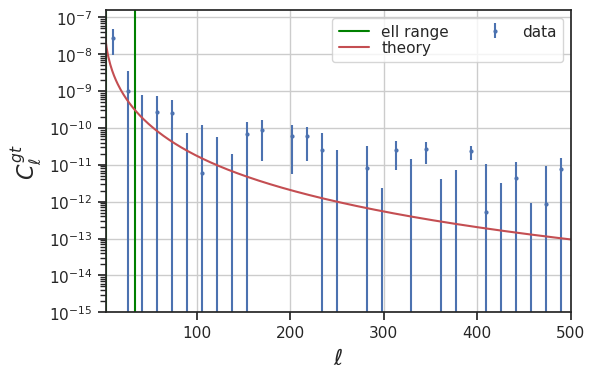

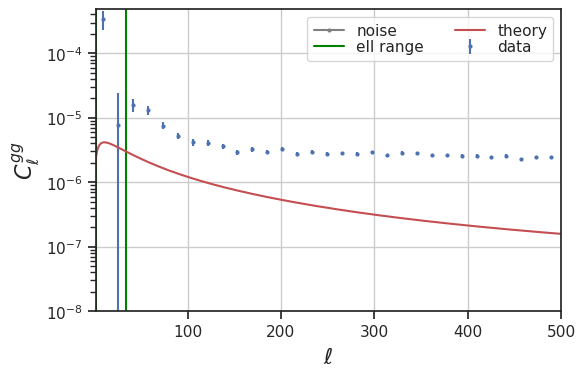

In [33]:
# 2 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gt', x_min=2, x_max=500, y_min=1e-15, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=500, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

# Correlations gk & gg

## Sigmas

In [10]:
# 1.5 mJy, SNR 7.5, deep fields, high ell range
experiment.print_correlation_statistics()

C_gg sigma: 509.21
C_gg chi squared: 106.71
C_gk sigma: 27.99
C_gk chi squared: 107.29


In [9]:
# 1.5 mJy, SNR 7.5, power law from likelihoods
experiment.print_correlation_statistics()

C_gg sigma: 159.99
C_gg chi squared: 34.56
C_gk sigma: 22.36
C_gk chi squared: 17.35


In [9]:
# 1.5 mJy, SNR 7.5, deepfields
experiment.print_correlation_statistics()

C_gg sigma: 159.72
C_gg chi squared: 122.53
C_gk sigma: 22.36
C_gk chi squared: 17.29


In [8]:
# 1.5 mJy, SNR 7.5, tomographer LS fit
experiment.print_correlation_statistics()

C_gg sigma: 177.83
C_gg chi squared: 186.11
C_gk sigma: 20.33
C_gk chi squared: 12.90


In [8]:
# 2 mJy, SNR 5, deep fields
experiment.print_correlation_statistics()

C_gg sigma: 207.31
C_gg chi squared: 273.08
C_gk sigma: 20.11
C_gk chi squared: 9.30


In [8]:
# 2 mJy, SNR 5, deep fields
experiment.print_correlation_statistics()

C_gg sigma: 191.29
C_gg chi squared: 170.75
C_gk sigma: 17.85
C_gk chi squared: 9.08


## 2mJy

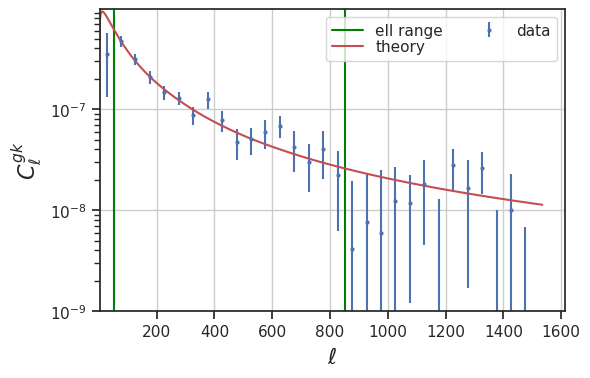

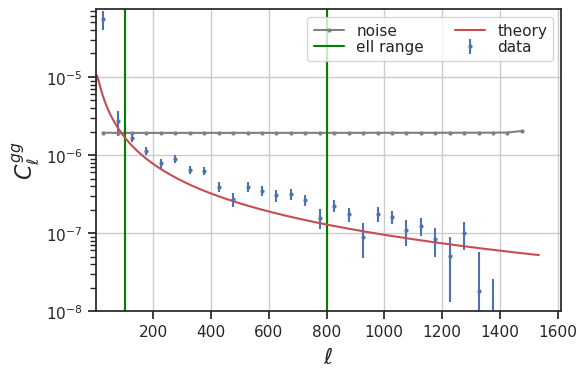

In [8]:
# 2 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

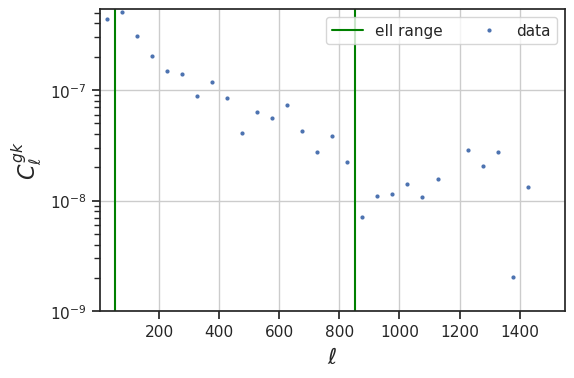

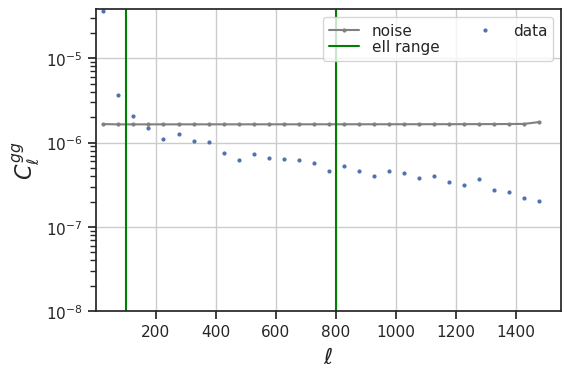

In [8]:
# 2 mJy, SNR 3, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

## 1.5mJy

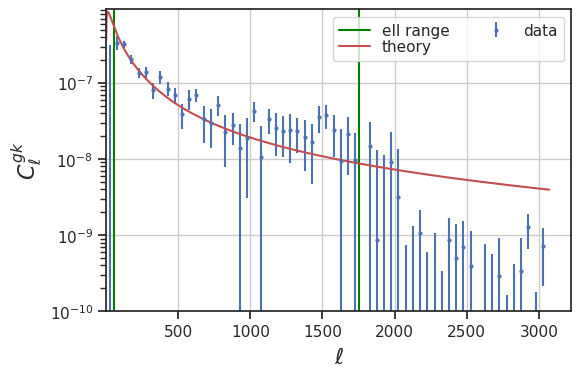

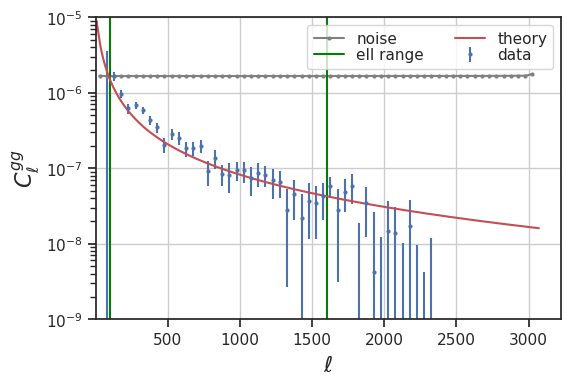

In [9]:
# 1.5 mJy, 7.5 SNR, power law from tomographer, inner mask, higher nside
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-10, y_max=None, x_scale='linear', y_scale='log', error_method='jackknife')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-9, y_max=1e-5, x_scale='linear', y_scale='log', error_method='jackknife')

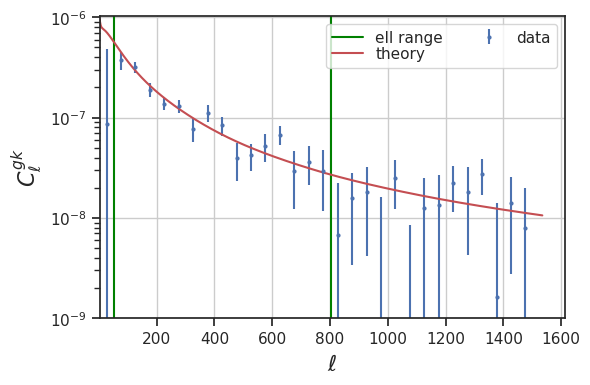

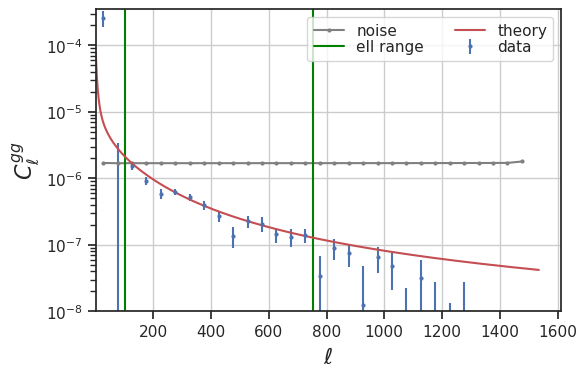

In [8]:
# 1.5 mJy, 7.5 SNR, power law from likelihoods, inner mask
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

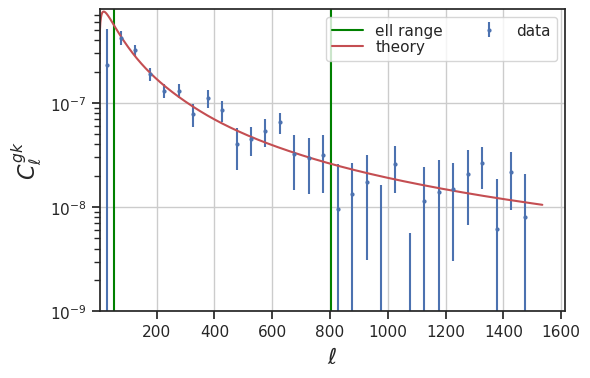

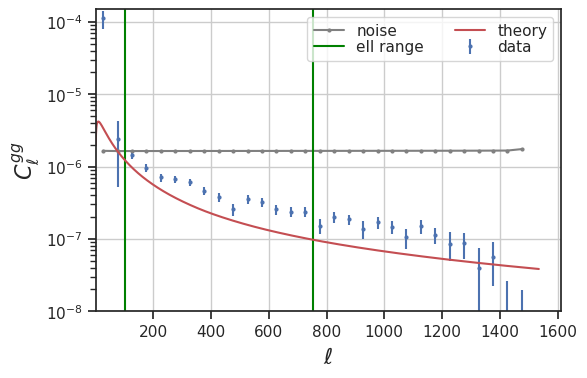

In [8]:
# 1.5 mJy, 7.5 SNR, deep fields 1.5mJy fix, inner mask, random weights
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

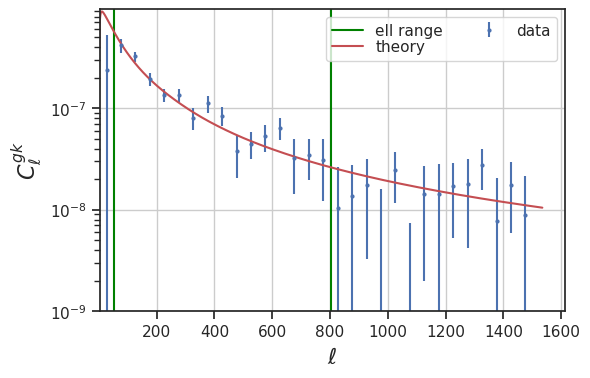

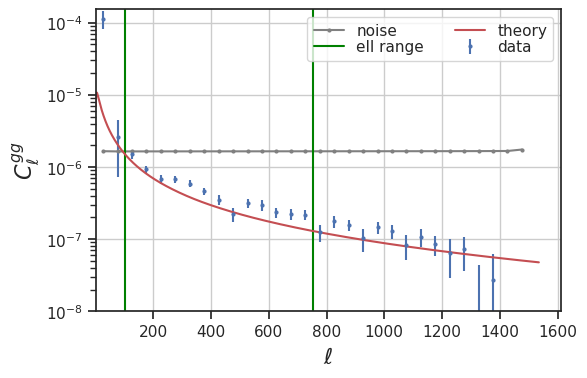

In [8]:
# 1.5 mJy, 7.5 SNR, deep fields 1.5mJy fix, inner mask, random weights
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

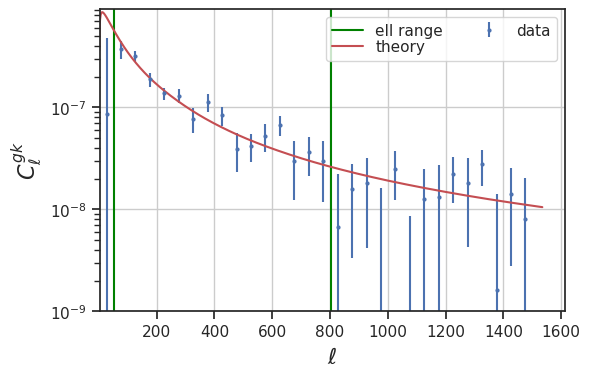

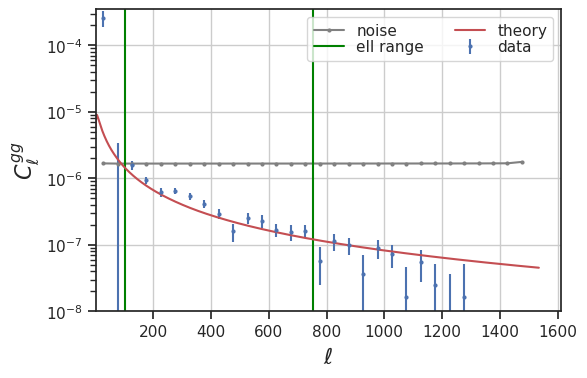

In [10]:
# 1.5 mJy, 7.5 SNR, deep fields, inner mask
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

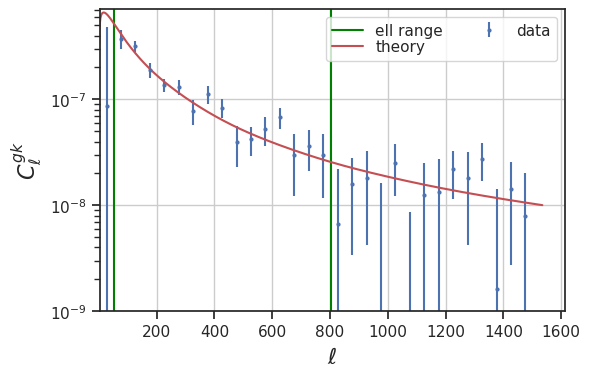

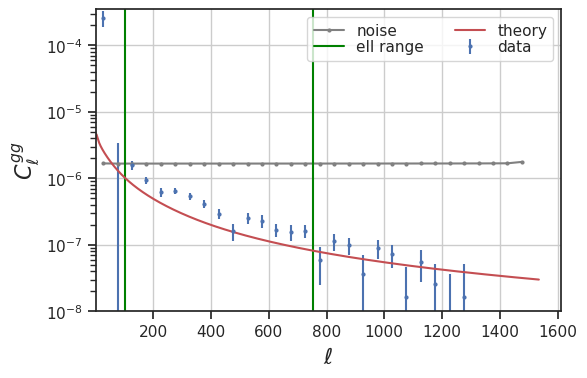

In [12]:
# 1.5 mJy, 7.5 SNR, tomographer LS fit, inner mask
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

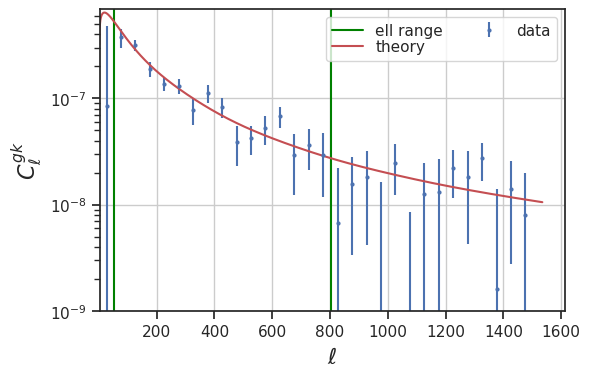

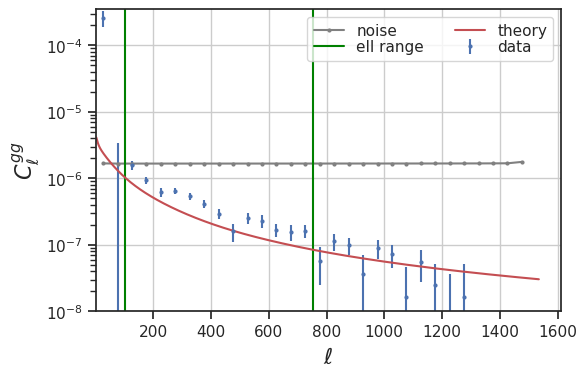

In [ ]:
# 1.5 mJy, 7.5 SNR, tomographer LS fit, inner mask
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

## 1mJy

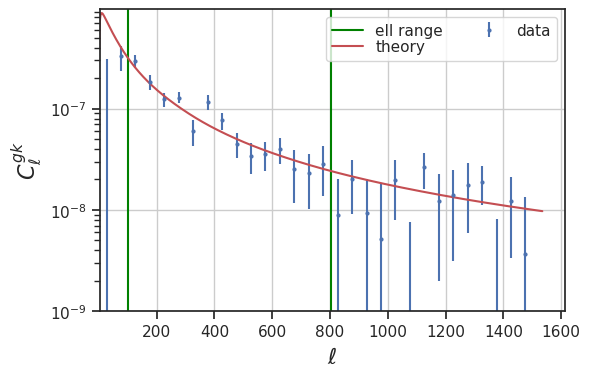

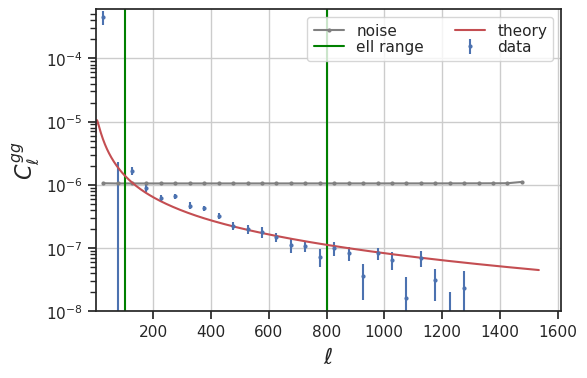

In [8]:
# 1 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

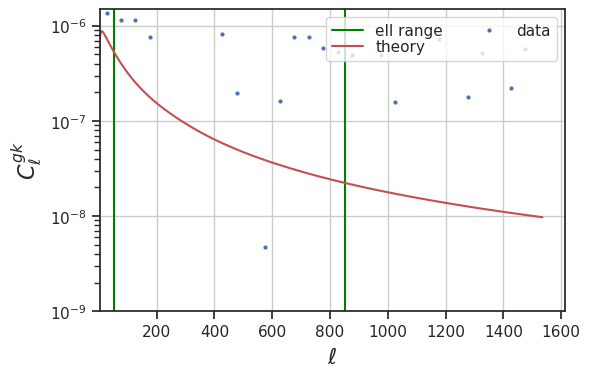

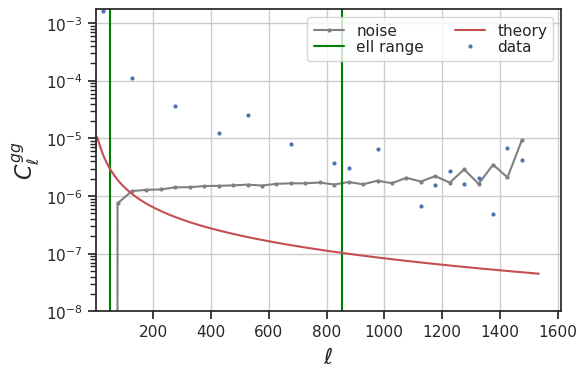

In [9]:
# 1 mJy, SNR 3, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

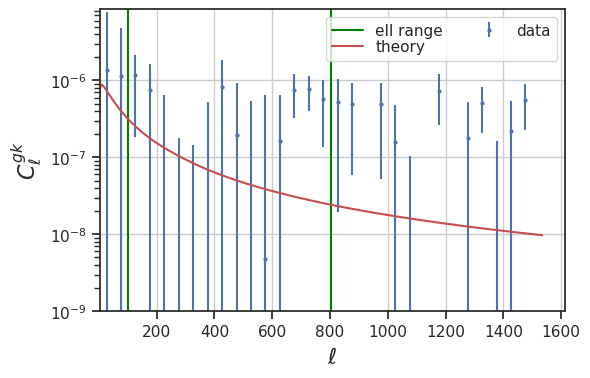

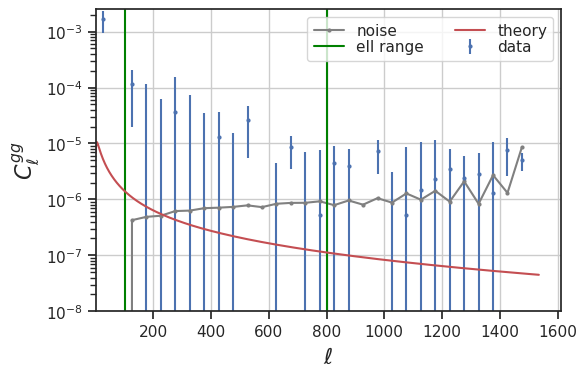

In [8]:
# 1 mJy, SNR 3, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

## 0.5mJy

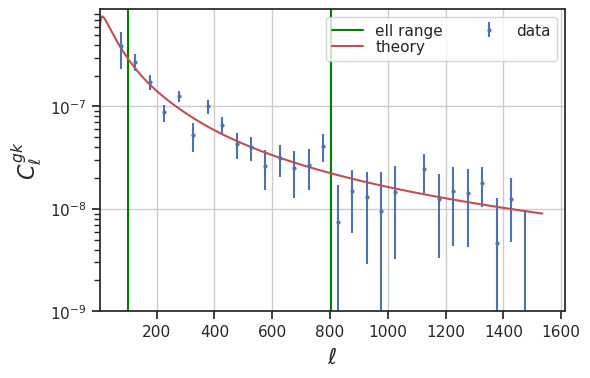

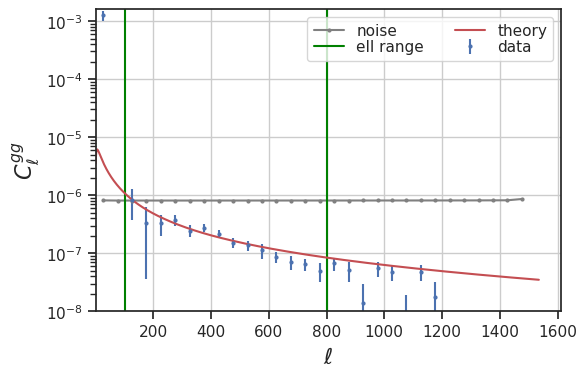

In [8]:
# 0.5 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

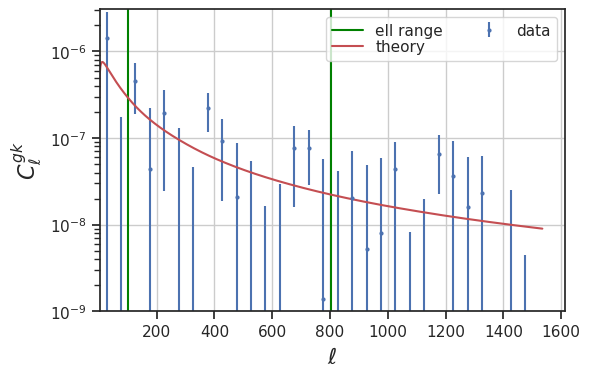

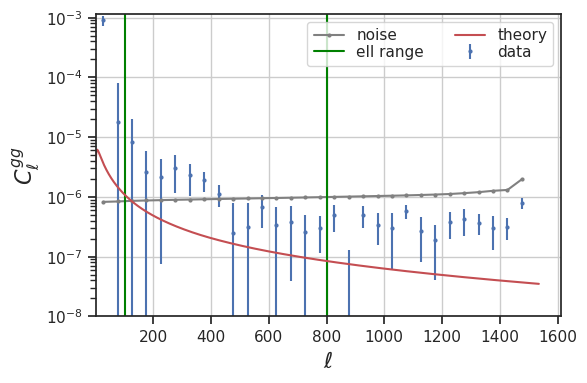

In [8]:
# 0.5 mJy, SNR 3, deep fields
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

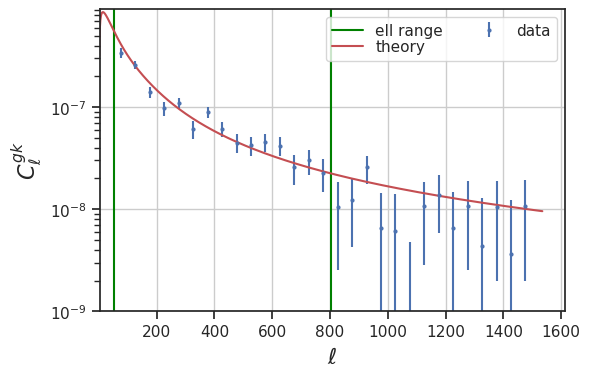

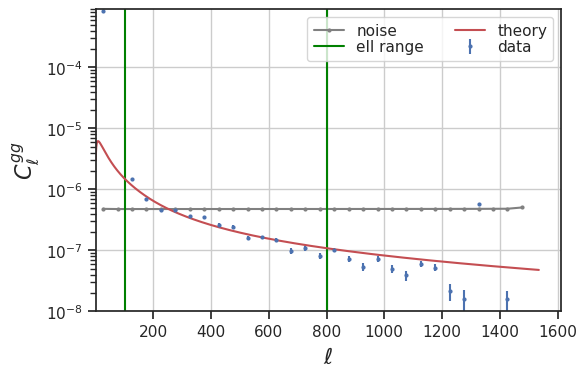

In [8]:
# Coverage, 0.5 mJy, SNR 3
plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log')
plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log')

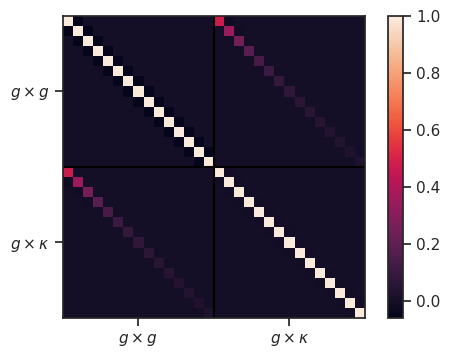

In [9]:
# Coverage, 2 mJy, SNR 3
plot_correlation_matrix(experiment)

# Correlations gT

## Sigmas

In [7]:
# Coverage 0.5 mJy, SNR 3, l < 34
experiment.print_correlation_statistics()

C_gg sigma: 115.71
C_gg chi squared: 2357913.91
C_gt sigma: 5.02
C_gt chi squared: 58.18


In [7]:
# Coverage 1 mJy, SNR 3, l < 66
experiment.print_correlation_statistics()

C_gg sigma: 69.52
C_gg chi squared: 88459.59
C_gt sigma: 3.55
C_gt chi squared: 23.19


In [7]:
# Coverage 1 mJy, SNR 3, l < 34
experiment.print_correlation_statistics()

C_gg sigma: 55.48
C_gg chi squared: 85393.29
C_gt sigma: 3.72
C_gt chi squared: 20.80


In [7]:
# Coverage 2 mJy, SNR 5, l < 34
experiment.print_correlation_statistics()

C_gg sigma: 34.94
C_gg chi squared: 12153.62
C_gt sigma: 3.47
C_gt chi squared: 15.86


## 0.5mJy

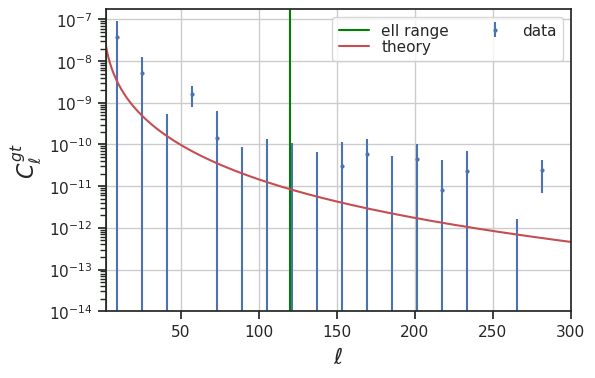

In [8]:
# 0.5 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gt', x_min=2, x_max=300, y_min=1e-14, y_max=None, x_scale='linear', y_scale='log')

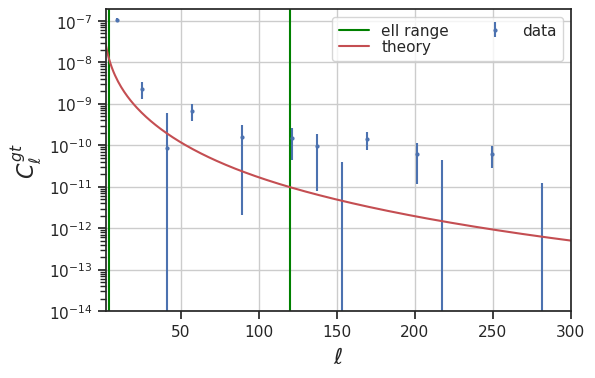

In [7]:
# Coverage, 0.5 mJy, SNR 3
plot_correlation(experiment, 'gt', x_min=2, x_max=300, y_min=1e-14, y_max=None, x_scale='linear', y_scale='log')

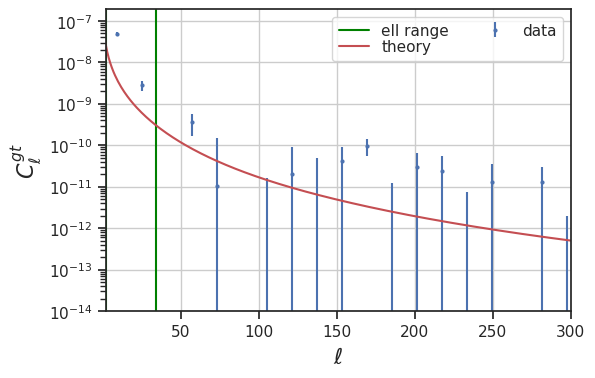

In [8]:
# Coverage, 0.5 mJy, SNR 3
plot_correlation(experiment, 'gt', x_min=2, x_max=300, y_min=1e-14, y_max=None, x_scale='linear', y_scale='log')

## 1mJy

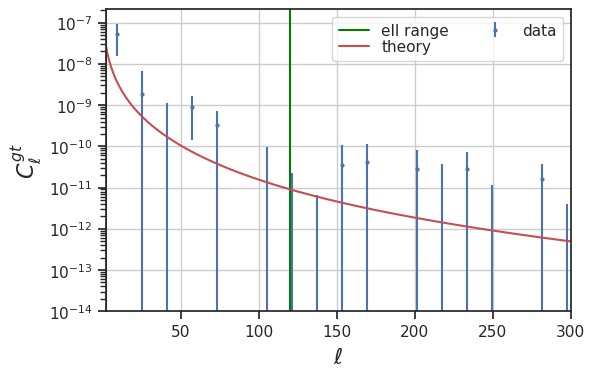

In [10]:
# 1 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gt', x_min=2, x_max=300, y_min=1e-14, y_max=None, x_scale='linear', y_scale='log')

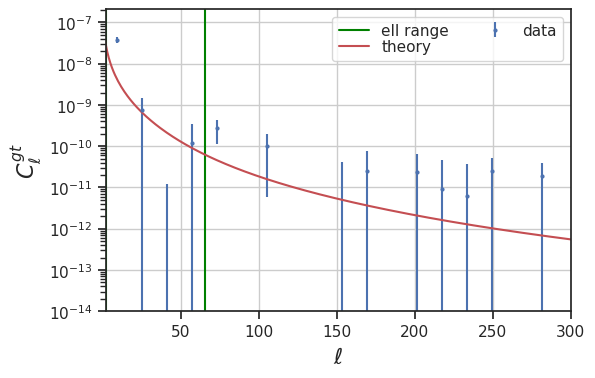

In [8]:
# Coverage, 1 mJy, SNR 3
plot_correlation(experiment, 'gt', x_min=2, x_max=300, y_min=1e-14, y_max=None, x_scale='linear', y_scale='log')

## 2mJy

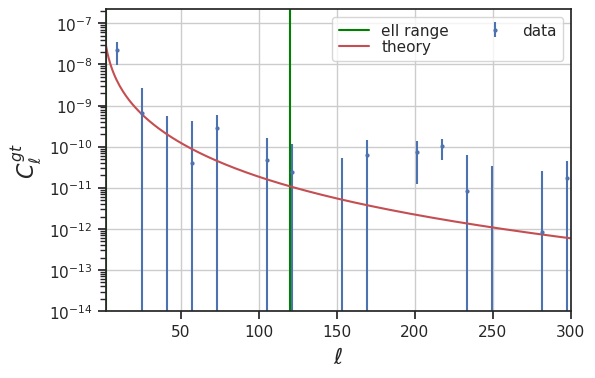

In [11]:
# 2 mJy, SNR 5, deep fields
plot_correlation(experiment, 'gt', x_min=2, x_max=300, y_min=1e-14, y_max=None, x_scale='linear', y_scale='log')

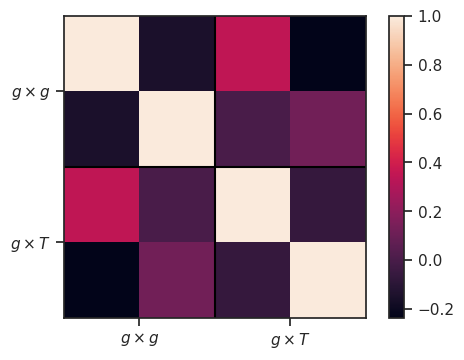

In [9]:
# coverage, 0.5 mJy, l < 34
plot_correlation_matrix(experiment)

# Chosing ell range

In [ ]:
 (+0.039, -0.042)
b_g_scaled =  (+0.252, -0.237)


In [24]:
def make_plot_two(matter_power_spectrum='halofit', corr_a='g', corr_b='g'):
    ell_arr = np.arange(3 * 512)
    
    with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
        cosmology_params = yaml.full_load(cosmology_file)['planck']
    cosmology_params['matter_power_spectrum'] = matter_power_spectrum
    cosmology_params['sigma8'] = 0.67
    cosmology = ccl.Cosmology(**cosmology_params)

    flux_cut = 1.5
    z_arr, n_arr = get_lotss_redshift_distribution(model='power_law', z_max=6, normalize=False,
        z_sfg=0.037, a=4.070, r=0.183, n=111286.565)

    b_g_scaled = 2.19
    bias_arr = b_g_scaled * np.ones(len(z_arr))
    bias_arr = bias_arr / ccl.growth_factor(cosmology, 1. / (1. + z_arr))

    tracers_dict = {
        'g': ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z_arr, n_arr), bias=(z_arr, bias_arr)),
        'k': ccl.CMBLensingTracer(cosmology, 1091),
    }
    correlation = ccl.angular_cl(cosmology, tracers_dict[corr_a], tracers_dict[corr_b], ell_arr)

    plt.plot(ell_arr, correlation, label='{}{}, {}'.format(corr_a, corr_b, matter_power_spectrum))

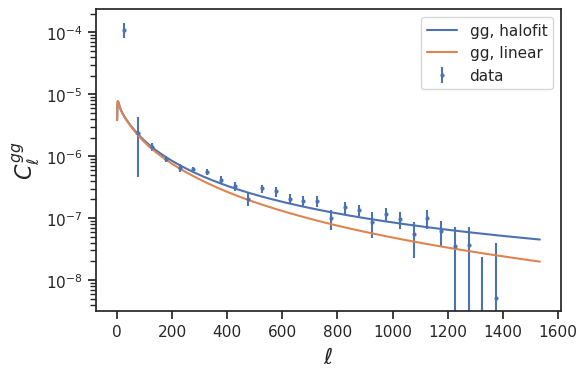

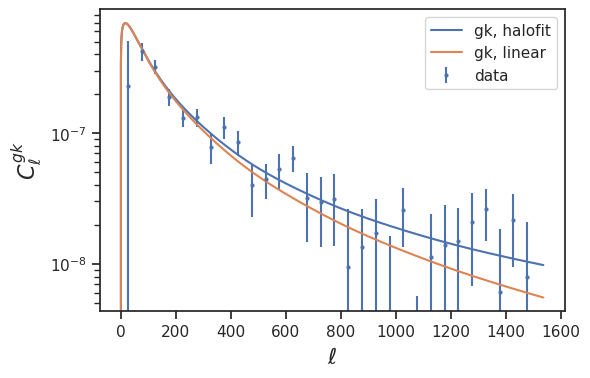

In [25]:
make_plot_two(matter_power_spectrum='halofit', corr_a='g', corr_b='g')
make_plot_two(matter_power_spectrum='linear', corr_a='g', corr_b='g')

correlation_symbol = 'gg'
y_err = experiment.errors['jackknife'][correlation_symbol]
ell_arr = experiment.binnings[correlation_symbol].get_effective_ells()
noise = experiment.noise_decoupled[correlation_symbol]
correlation_dict = experiment.data_correlations
A_sn = 1.04
data_to_plot = correlation_dict[correlation_symbol] - A_sn * noise
plt.errorbar(ell_arr, data_to_plot, yerr=y_err, fmt='ob', label='data', markersize=2)

plt.legend()
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{{{}}}$'.format('gg'), fontsize=16)
plt.show()

make_plot_two(matter_power_spectrum='halofit', corr_a='g', corr_b='k')
make_plot_two(matter_power_spectrum='linear', corr_a='g', corr_b='k')

correlation_symbol = 'gk'
y_err = experiment.errors['jackknife'][correlation_symbol]
ell_arr = experiment.binnings[correlation_symbol].get_effective_ells()
correlation_dict = experiment.data_correlations
data_to_plot = correlation_dict[correlation_symbol]
plt.errorbar(ell_arr, data_to_plot, yerr=y_err, fmt='ob', label='data', markersize=2)

plt.legend()
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{{{}}}$'.format('gk'), fontsize=16)
plt.show()

In [10]:
def make_plot():
    with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
        cosmology_params = yaml.full_load(cosmology_file)['planck']
    cosmology_params['matter_power_spectrum'] = 'halofit'
    cosmology = ccl.Cosmology(**cosmology_params)
    
    flux_cut = 1.5
    z_arr, n_arr = get_lotss_redshift_distribution(flux_cut=1.5, model='deep_fields', z_max=6, normalize=False)
    
    b_g_scaled = 1.3
    bias_arr = b_g_scaled * np.ones(len(z_arr))
    bias_arr = bias_arr / ccl.growth_factor(cosmology, 1. / (1. + z_arr))
    
    chi = ccl.comoving_radial_distance(cosmology, 1. / (1. + z_arr))

    for ell in [250, 400, 500, 750, 1200]:
        k = (ell + 0.5) / chi
        plt.plot(k, bias_arr * n_arr, label=r'$\ell = {}$'.format(ell))
    
    ax = plt.gca()
    ax.axvspan(0.1, 0.2, alpha=.2, color='blue')

    plt.legend()
    plt.xscale('log')
    plt.xlabel('k')
    plt.ylabel('b * N(z)')

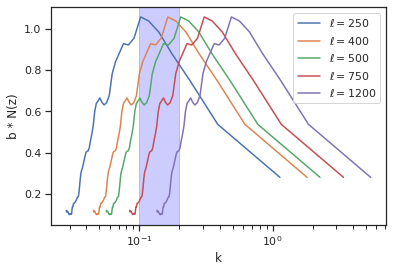

In [11]:
%matplotlib inline

make_plot()

plt.show()

# Cut comparison

In [5]:
def tmp_fun(flux_min_cut):
    experiments = {}

    for signal_to_noise in [3, 5, 7.5]:
        config = get_config('LoTSS_DR2')
        config.read_data_correlations_flag = True
        config.flux_min_cut = flux_min_cut
        config.signal_to_noise = signal_to_noise

        exp = Experiment(config, set_data=False, set_maps=False)
        exp.set_correlations(with_covariance=False)
        experiments[signal_to_noise] = exp

    for signal_to_noise in experiments:
        experiment = experiments[signal_to_noise]
        title = '{}mJy, {} SNR'.format(flux_min_cut, signal_to_noise)
        plot_correlation(experiment, 'gk', x_min=2, x_max=None, y_min=1e-9, y_max=None, x_scale='linear', y_scale='log', title=title)
        plot_correlation(experiment, 'gg', x_min=2, x_max=None, y_min=1e-8, y_max=None, x_scale='linear', y_scale='log', title=title)

28/02/2022 14:57:27 INFO: Setting data correlations..
28/02/2022 14:57:27 INFO: Setting theory correlations..
28/02/2022 14:57:28 INFO: Setting covariance..
28/02/2022 14:57:28 INFO: Setting data correlations..
28/02/2022 14:57:28 INFO: Setting theory correlations..
28/02/2022 14:57:28 INFO: Setting covariance..
28/02/2022 14:57:28 INFO: Setting data correlations..
28/02/2022 14:57:28 INFO: Setting theory correlations..
28/02/2022 14:57:29 INFO: Setting covariance..


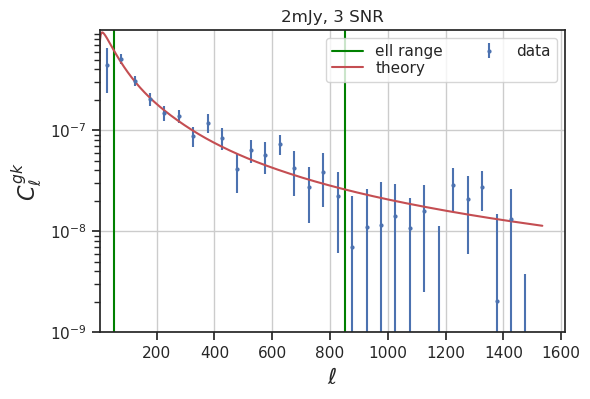

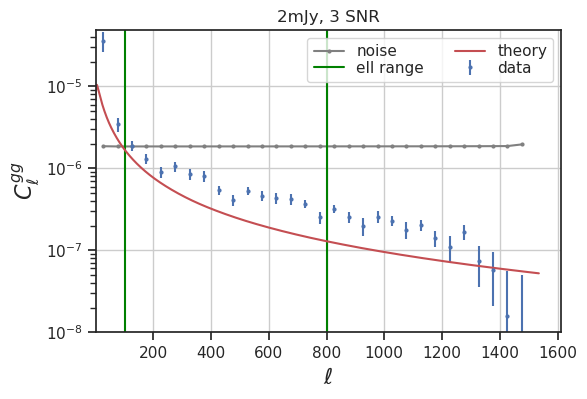

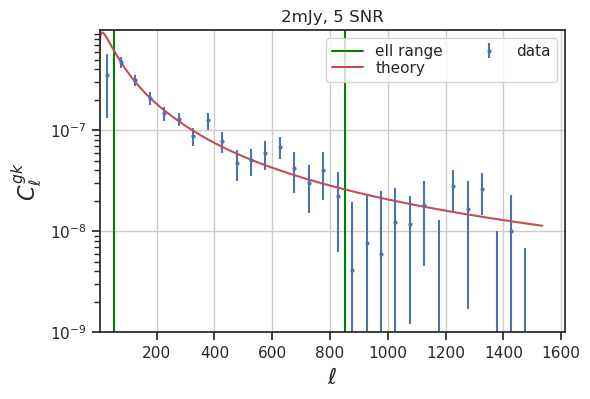

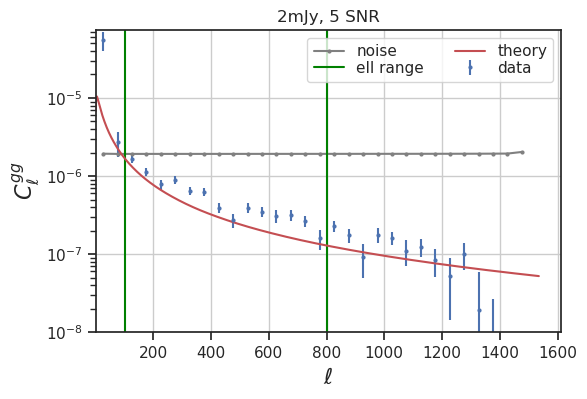

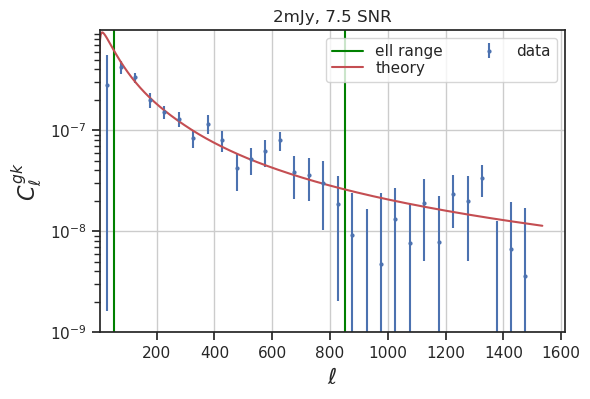

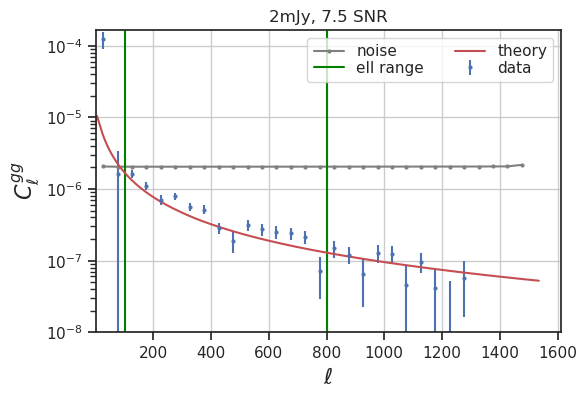

In [19]:
tmp_fun(flux_min_cut=2)

01/03/2022 19:51:34 INFO: Setting data correlations..
01/03/2022 19:51:34 INFO: Setting theory correlations..
01/03/2022 19:51:34 INFO: Setting covariance..
01/03/2022 19:51:34 INFO: Setting data correlations..
01/03/2022 19:51:34 INFO: Setting theory correlations..
01/03/2022 19:51:34 INFO: Setting covariance..
01/03/2022 19:51:34 INFO: Setting data correlations..
01/03/2022 19:51:34 INFO: Setting theory correlations..
01/03/2022 19:51:34 INFO: Setting covariance..


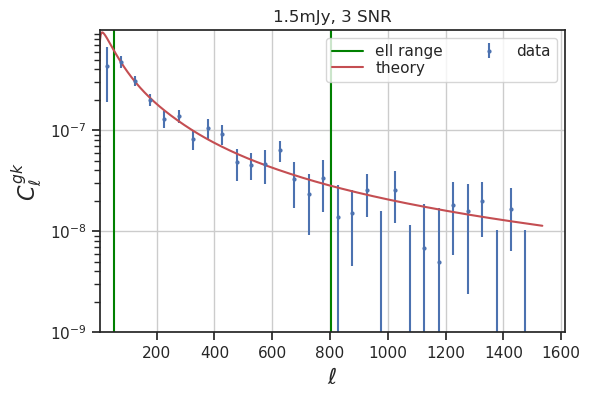

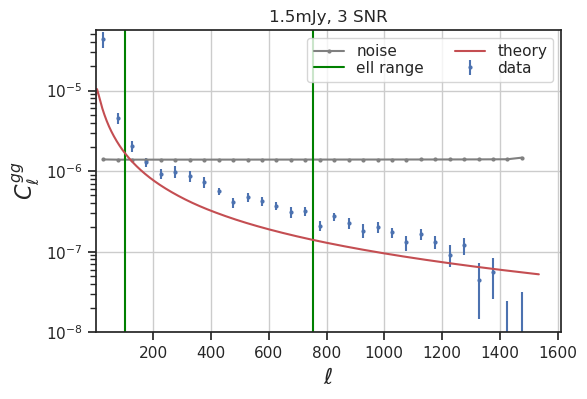

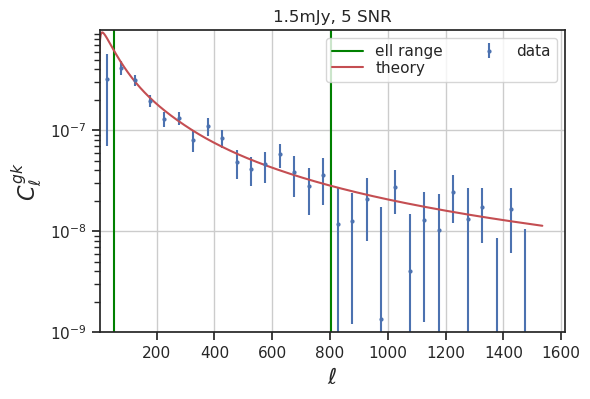

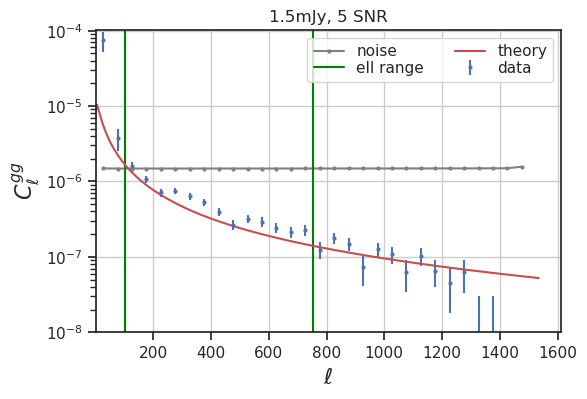

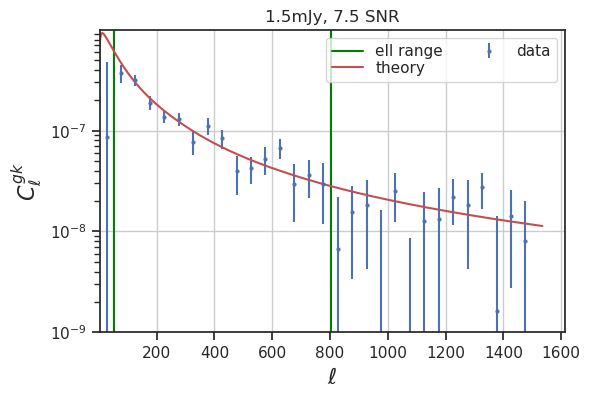

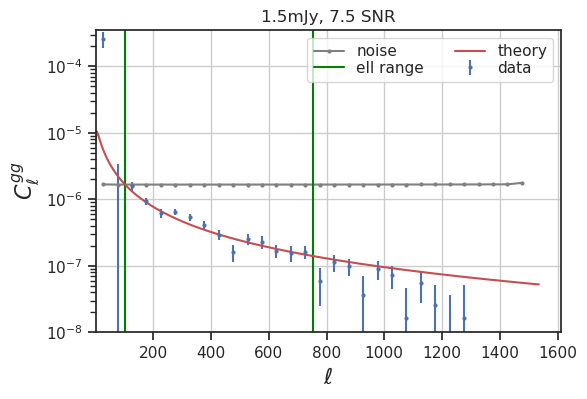

In [8]:
tmp_fun(flux_min_cut=1.5)

28/02/2022 14:58:05 INFO: Setting data correlations..
28/02/2022 14:58:05 INFO: Setting theory correlations..
28/02/2022 14:58:05 INFO: Setting covariance..
28/02/2022 14:58:05 INFO: Setting data correlations..
28/02/2022 14:58:05 INFO: Setting theory correlations..
28/02/2022 14:58:06 INFO: Setting covariance..
28/02/2022 14:58:06 INFO: Setting data correlations..
28/02/2022 14:58:06 INFO: Setting theory correlations..
28/02/2022 14:58:06 INFO: Setting covariance..


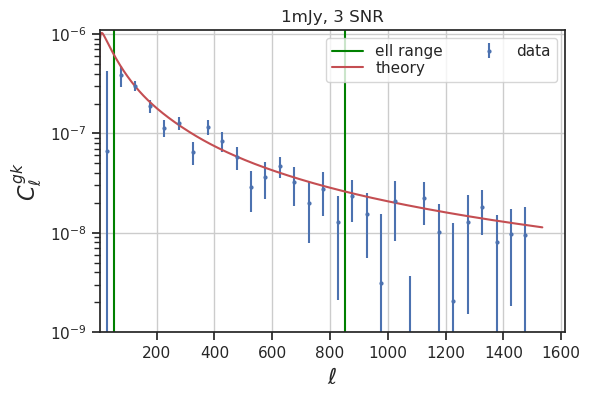

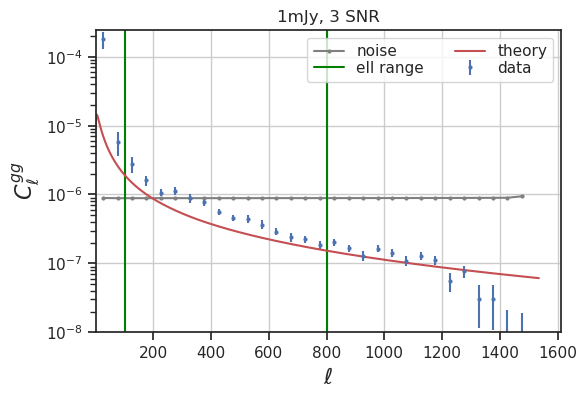

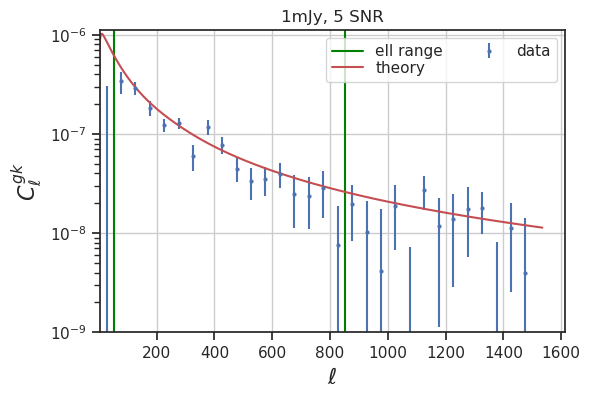

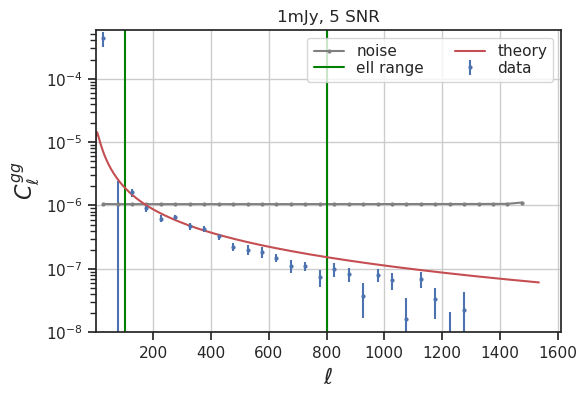

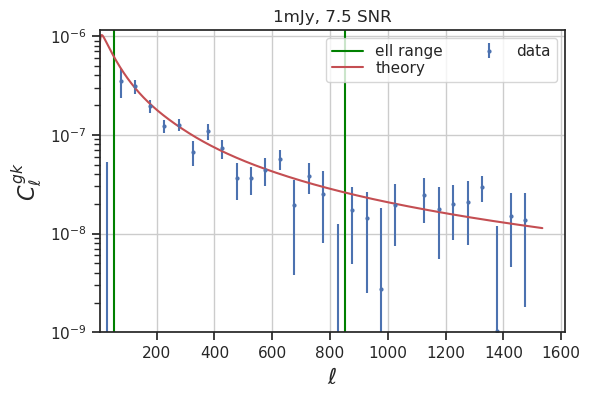

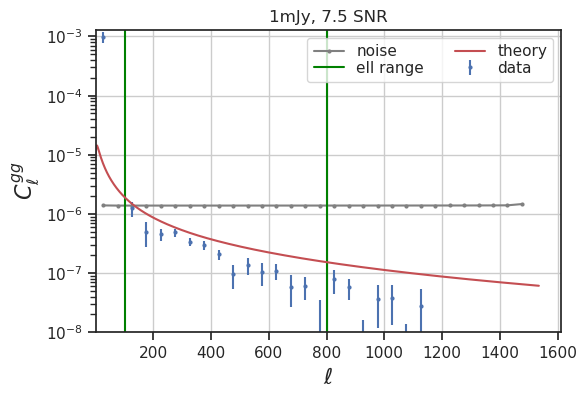

In [20]:
tmp_fun(flux_min_cut=1)

28/02/2022 15:03:07 INFO: Setting data correlations..
28/02/2022 15:03:07 INFO: Setting theory correlations..
28/02/2022 15:03:07 INFO: Setting covariance..
28/02/2022 15:03:07 INFO: Setting data correlations..
28/02/2022 15:03:07 INFO: Setting theory correlations..
28/02/2022 15:03:07 INFO: Setting covariance..
28/02/2022 15:03:07 INFO: Setting data correlations..
28/02/2022 15:03:07 INFO: Setting theory correlations..
28/02/2022 15:03:08 INFO: Setting covariance..


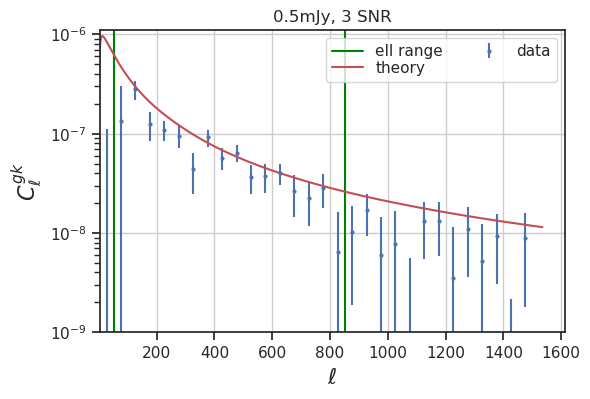

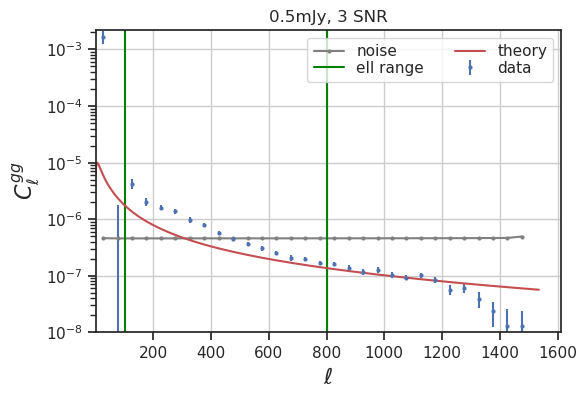

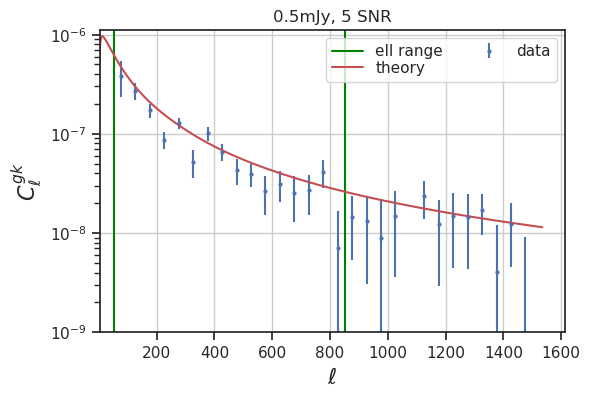

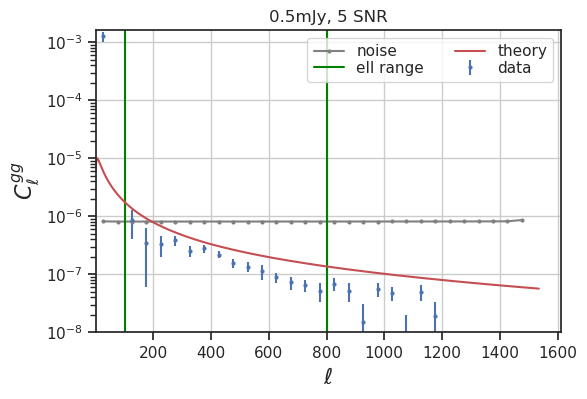

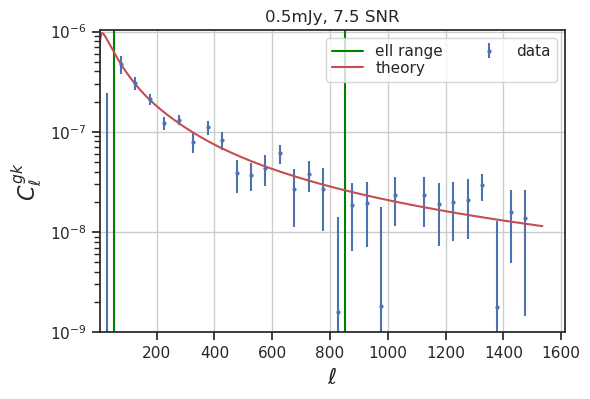

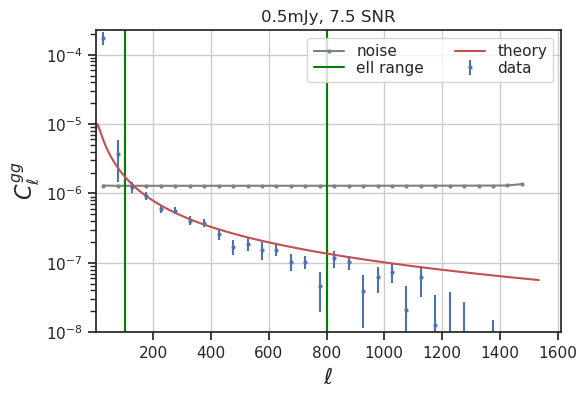

In [21]:
tmp_fun(flux_min_cut=0.5)

# Theoretical models

## z-tail and cosmology

In [5]:
config = get_config('LoTSS_DR2')
display(config)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': True,
 'lss_mask_name': 'Mask_coverage',
 'nside': 512,
 'flux_min_cut': 1,
 'signal_to_noise': 3,
 'new_z_dist': True,
 'z_tail': 1.1,
 'z_sfg': 0.24,
 'z_agn': 1.5,
 'r': 0.007,
 'scale_bias': True,
 'bias': 1.2,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'l_range': {'gg': [2, 120], 'gt': [2, 120]},
 'ells_per_bin': {'gg': 16, 'gt': 16},
 'starting_params': {'bias': [2.1, 0.5], 'sigma8': [0.83, 0.1]},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

In [5]:
to_plot_tuples = [('bias', np.arange(0.8, 2.0, 0.1)), ('z_tail', np.arange(0.8, 2.0, 0.1)), ('Omega_c_b_frac', np.arange(0.5, 1.6, 0.1)), ('Omega_k', np.arange(-0.2, 0.21, 0.05))]
to_plot_correlations = ['gg', 'gk', 'gt']

config = get_config('LoTSS_DR2')
l_arr = np.arange(3 * config['nside'])

correlations = {}
for to_plot_tuple in to_plot_tuples:
    param_name = to_plot_tuple[0]
    param_values = to_plot_tuple[1]

    correlations[param_name] = {}
    for param_value in param_values:
        omega_param = None
        if param_name in config:
            config[param_name] = param_value
        else:
            omega_param = (param_name, param_value)
        correlations[param_name][param_value] = get_theory_correlations(config, to_plot_correlations, l_arr, omega_param)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/pyccl/cls.py:46: CCLWarning: CCL does not properly use the hyperspherical Bessel functions when computing angular power spectra in non-flat cosmologies!
  category=CCLWarning)


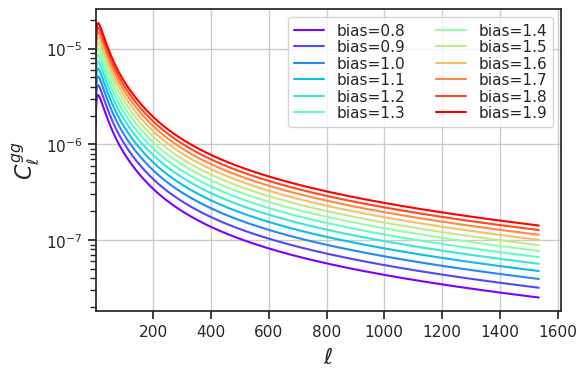

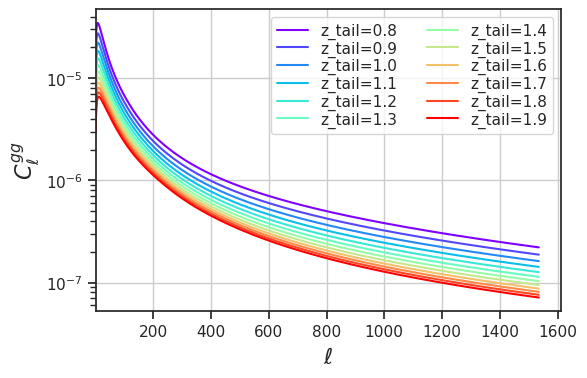

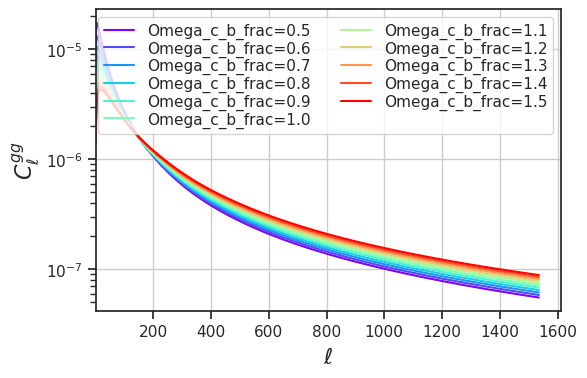

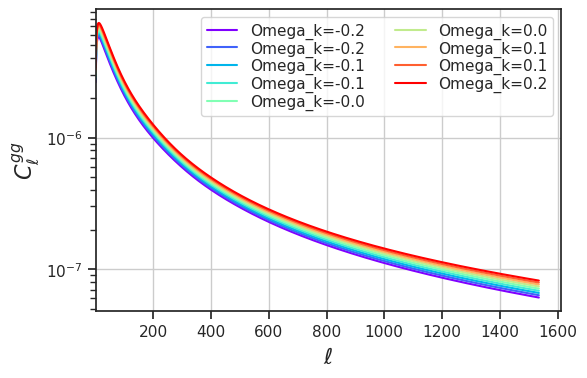

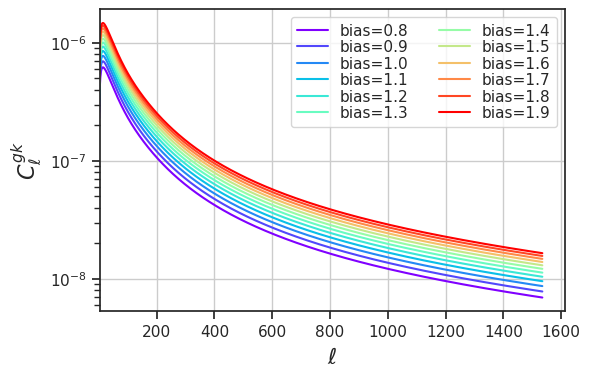

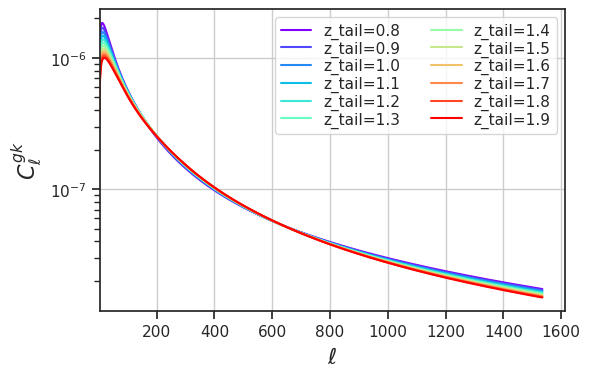

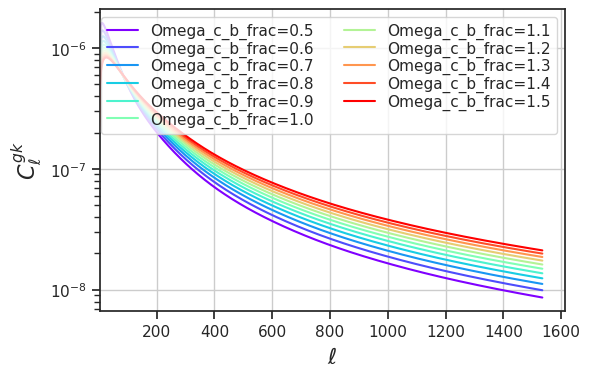

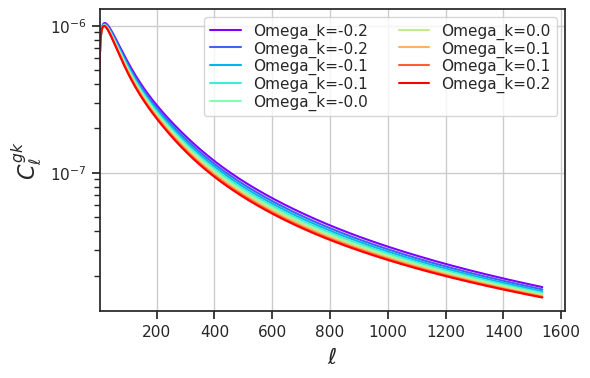

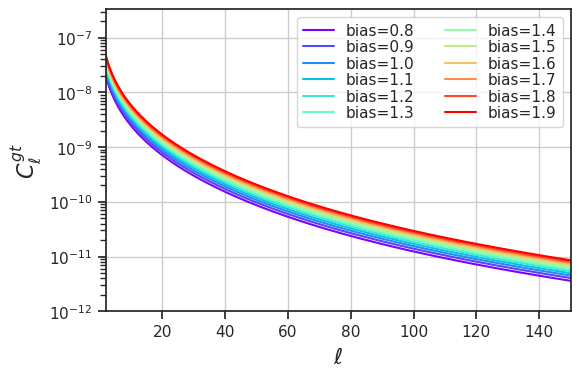

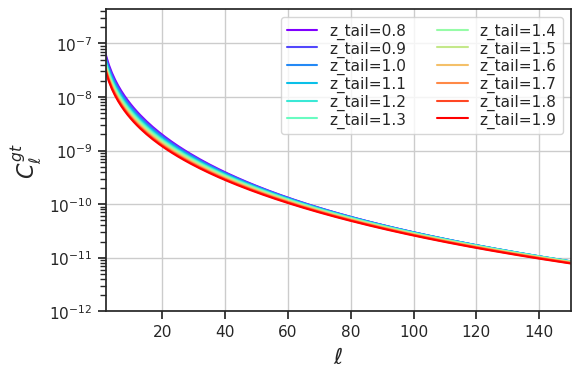

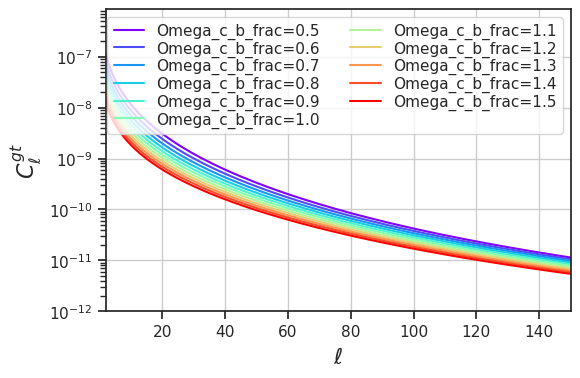

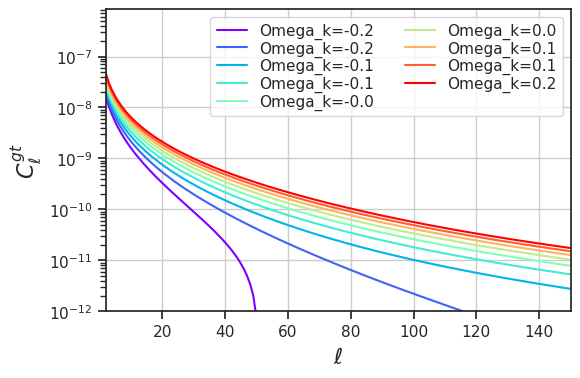

In [6]:
for correlation_symbol in to_plot_correlations:
    for param_name, param_values in to_plot_tuples:
        plt.figure()

        colors = plt.cm.rainbow(np.linspace(0, 1, len(param_values)))
        for i, param_value in enumerate(param_values):
            plt.plot(l_arr, correlations[param_name][param_value][correlation_symbol], label='{}={:.1f}'.format(param_name, param_value), c=colors[i])

        plt.xlim(xmin=2, xmax=None)
        if correlation_symbol == 'gt':
            plt.xlim(xmin=2, xmax=150)
            plt.ylim(ymin=1e-12, ymax=None)

        plt.xscale('linear')
        plt.yscale('log')
        plt.xlabel('$\\ell$', fontsize=16)
        plt.ylabel('$C_\\ell^{{{}}}$'.format(correlation_symbol), fontsize=16)
        plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
        plt.grid()
        plt.show()

## AGN power law

In [4]:
config = get_config('LoTSS_DR2')
display(config)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': True,
 'lss_mask_name': 'Mask_coverage',
 'nside': 512,
 'flux_min_cut': 2,
 'signal_to_noise': 5,
 'dn_dz_model': 'power_law',
 'z_tail': 1.3,
 'z_sfg': 0.13,
 'a': 4.66,
 'r': 0.94,
 'scale_bias': True,
 'bias': 1.4,
 'read_data_correlations_flag': False,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'l_range': {'gg': [52, 802], 'gk': [52, 802]},
 'ells_per_bin': {'gg': 50, 'gk': 50},
 'starting_params': {'bias': [2.1, 0.5], 'sigma8': [0.83, 0.1]},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

In [8]:
config = get_config('LoTSS_DR2')
to_plot_correlations = ['gg', 'gk', 'gt']
to_plot_tuples = [
    ('z_sfg', np.arange(0.05, 0.21, 0.02)),
    ('a', np.arange(4.2, 5.0, 0.1)),
    ('r', np.arange(0.8, 1.0, 0.02)),
    ('bias', np.arange(1.0, 1.8, 0.1)),
]

l_arr = np.arange(3 * config['nside'])

correlations = {}
for to_plot_tuple in to_plot_tuples:
    param_name = to_plot_tuple[0]
    param_values = to_plot_tuple[1]

    correlations[param_name] = {}
    for param_value in param_values:
        config[param_name] = param_value
        correlations[param_name][param_value] = get_theory_correlations(config, to_plot_correlations, l_arr)

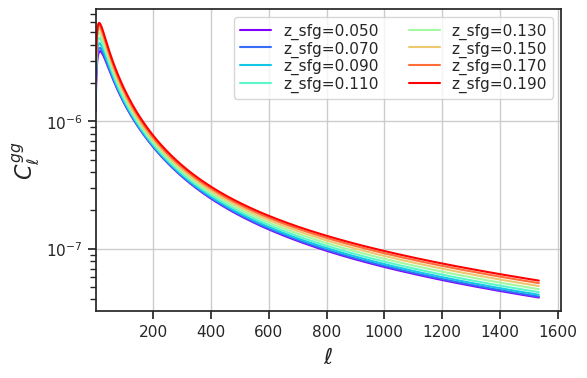

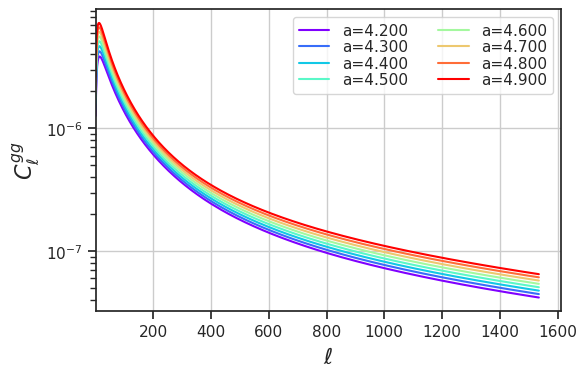

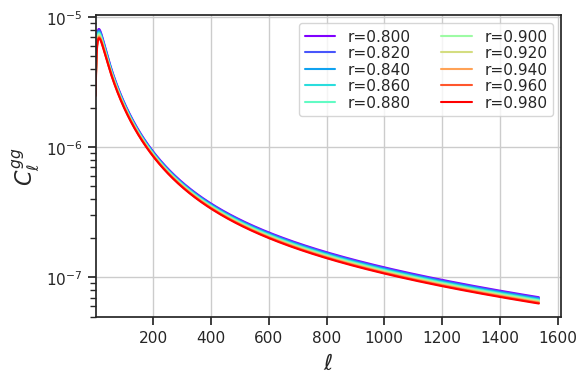

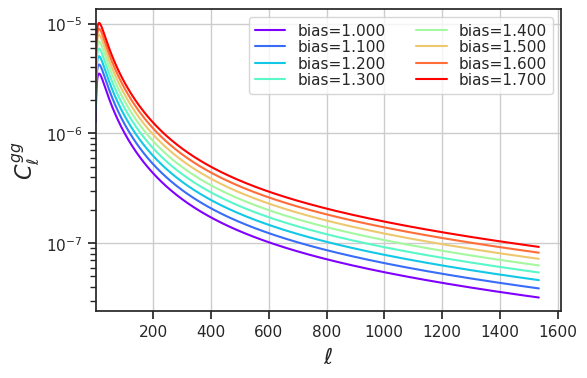

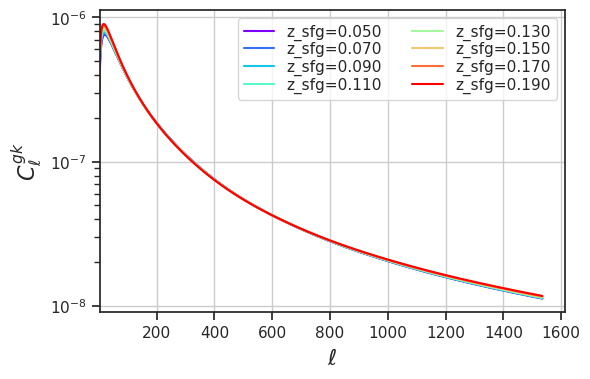

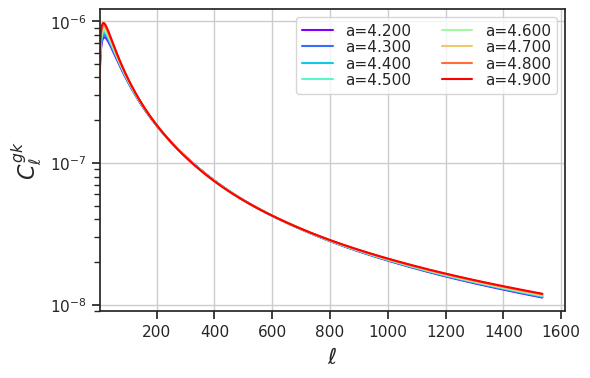

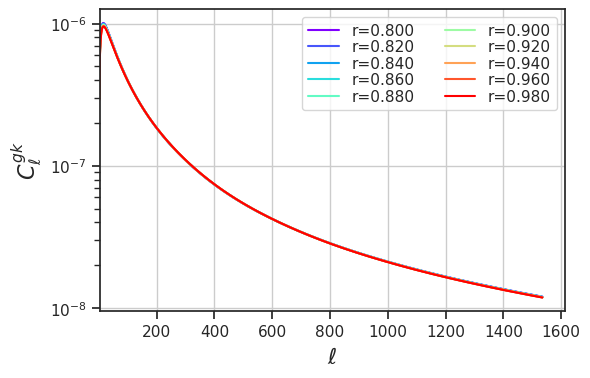

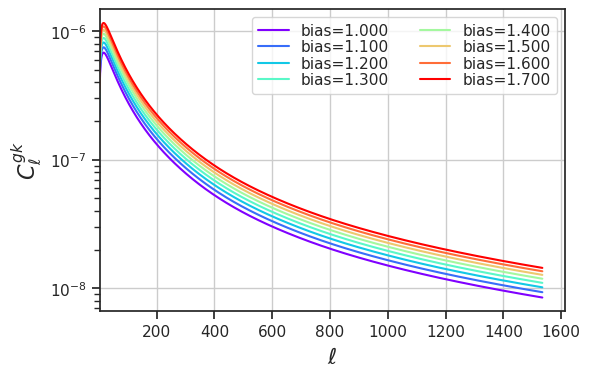

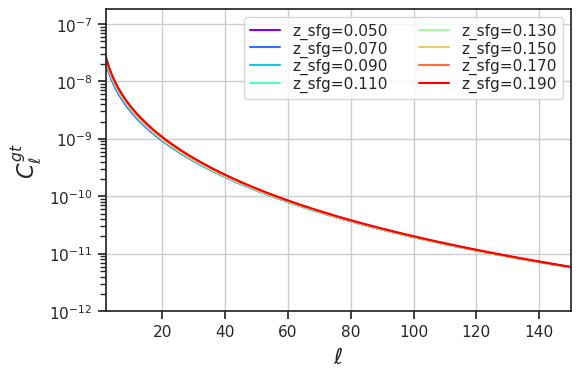

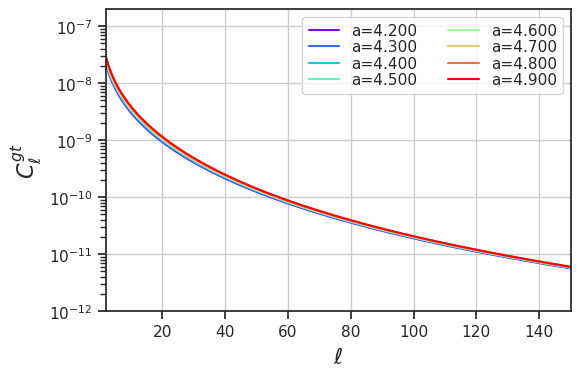

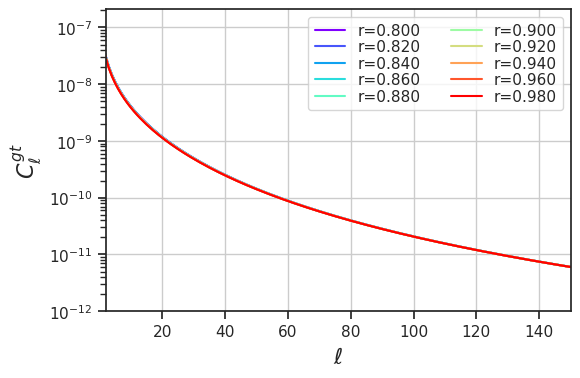

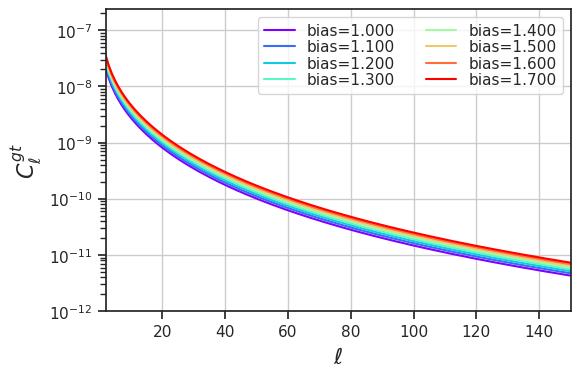

In [9]:
for correlation_symbol in to_plot_correlations:
    for param_name, param_values in to_plot_tuples:
        plt.figure()

        colors = plt.cm.rainbow(np.linspace(0, 1, len(param_values)))
        for i, param_value in enumerate(param_values):
            plt.plot(l_arr, correlations[param_name][param_value][correlation_symbol], label='{}={:.3f}'.format(param_name, param_value), c=colors[i])

        plt.xlim(xmin=2, xmax=None)
        if correlation_symbol == 'gt':
            plt.xlim(xmin=2, xmax=150)
            plt.ylim(ymin=1e-12, ymax=None)

        plt.xscale('linear')
        plt.yscale('log')
        plt.xlabel('$\\ell$', fontsize=16)
        plt.ylabel('$C_\\ell^{{{}}}$'.format(correlation_symbol), fontsize=16)
        plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
        plt.grid()
        plt.show()

# Bias model

In [11]:
config = get_config('LoTSS_DR2')
display(config)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': False,
 'lss_mask_name': 'Mask_coverage',
 'nside': 512,
 'flux_min_cut': 2,
 'signal_to_noise': 5,
 'dn_dz_model': 'power_law',
 'z_tail': 1.3,
 'z_sfg': 0.15,
 'a': 4.8,
 'r': 0.91,
 'bias_model': 'polynomial',
 'b_0_scaled': 1.4,
 'b_0': 1,
 'b_1': 1,
 'b_2': 1,
 'read_data_correlations_flag': True,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'l_range': {'gg': [52, 802], 'gk': [52, 802]},
 'ells_per_bin': {'gg': 50, 'gk': 50},
 'starting_params': {'bias': [2.1, 0.5], 'sigma8': [0.83, 0.1]},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

In [12]:
config = get_config('LoTSS_DR2')
to_plot_correlations = ['gg', 'gk', 'gt']
to_plot_tuples = [
    ('b_0', np.arange(1.0, 2.1, 0.1)),
    ('b_1', np.arange(1.0, 2.1, 0.1)),
    ('b_2', np.arange(1.0, 2.1, 0.1)),
]

l_arr = np.arange(3 * config['nside'])

correlations = {}
for to_plot_tuple in to_plot_tuples:
    param_name = to_plot_tuple[0]
    param_values = to_plot_tuple[1]

    correlations[param_name] = {}
    for param_value in param_values:
        config[param_name] = param_value
        correlations[param_name][param_value] = get_theory_correlations(config, to_plot_correlations, l_arr)

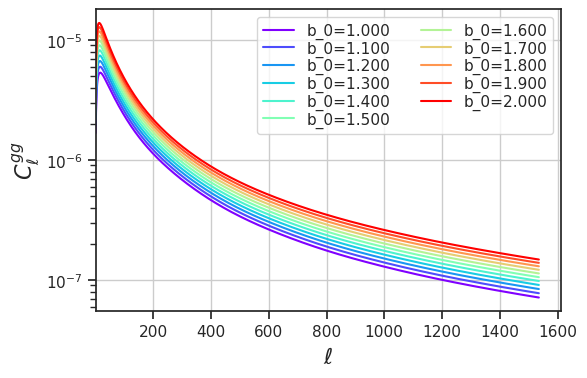

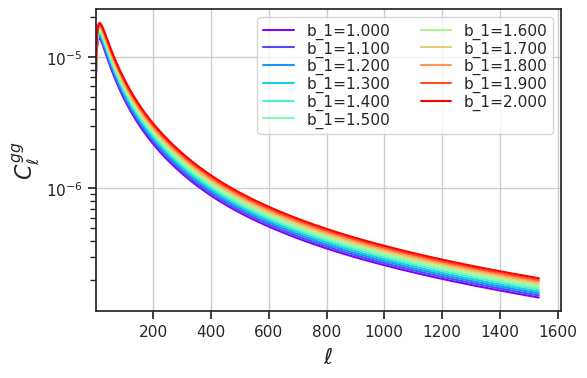

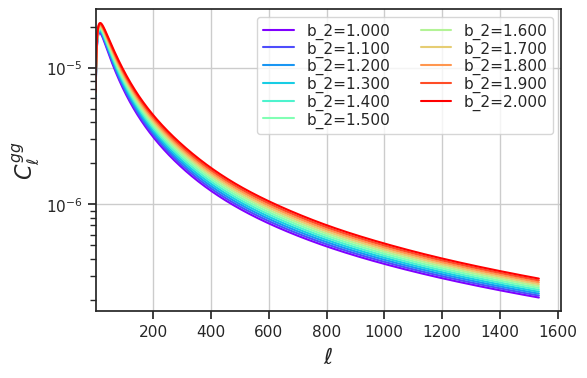

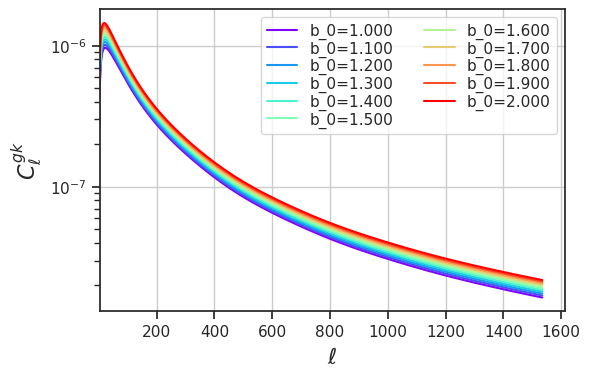

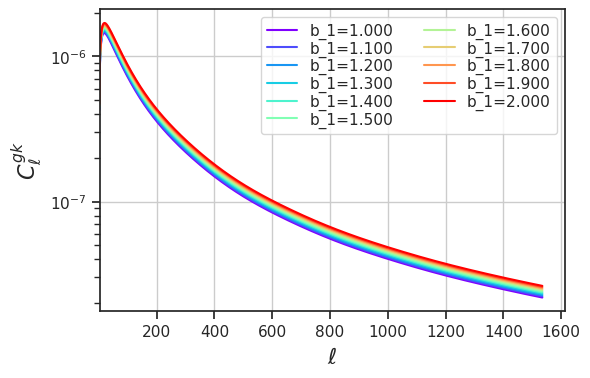

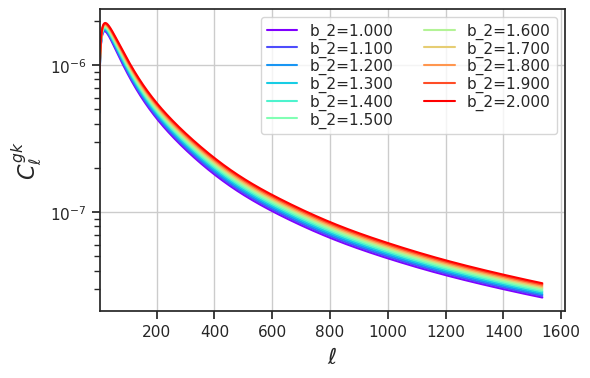

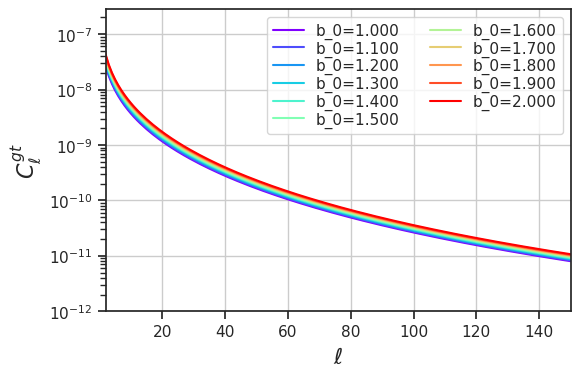

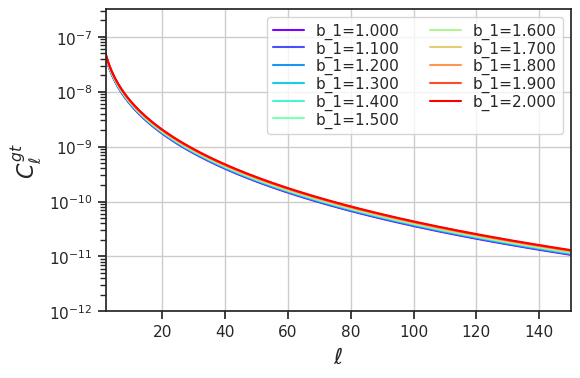

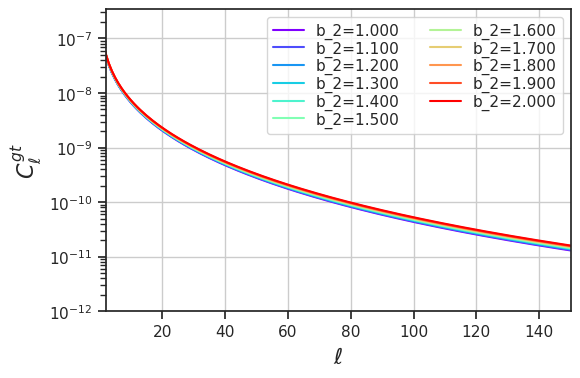

In [13]:
for correlation_symbol in to_plot_correlations:
    for param_name, param_values in to_plot_tuples:
        plt.figure()

        colors = plt.cm.rainbow(np.linspace(0, 1, len(param_values)))
        for i, param_value in enumerate(param_values):
            plt.plot(l_arr, correlations[param_name][param_value][correlation_symbol], label='{}={:.3f}'.format(param_name, param_value), c=colors[i])

        plt.xlim(xmin=2, xmax=None)
        if correlation_symbol == 'gt':
            plt.xlim(xmin=2, xmax=150)
            plt.ylim(ymin=1e-12, ymax=None)

        plt.xscale('linear')
        plt.yscale('log')
        plt.xlabel('$\\ell$', fontsize=16)
        plt.ylabel('$C_\\ell^{{{}}}$'.format(correlation_symbol), fontsize=16)
        plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
        plt.grid()
        plt.show()

# Multicomponent shot noise

In [20]:
flux_cut = 1
signal_to_noise = 3

In [21]:
fname = 'LoTSS_DR2/LoTSS_DR2_{}__mask_optical__{}mJy_snr={}_nside=512_gg-gk_bin=50'
corr_opt_msk_opt = read_correlations(fname.format('opt', flux_cut, signal_to_noise))
corr_srl_msk_opt = read_correlations(fname.format('srl', flux_cut, signal_to_noise))

fname = 'LoTSS_DR2/LoTSS_DR2_{}__mask_inner__{}mJy_snr={}_nside=512_gg-gk_bin=50'
corr_srl_msk_inner = read_correlations(fname.format('srl', flux_cut, signal_to_noise))

In [22]:
multi_noise, multi_noise_err_gauss = corr_srl_msk_inner['nl_gg_multicomp'][0], corr_srl_msk_inner['error_nl_gg_multicomp_gauss'][0]
multi_noise_err_jackknife = corr_srl_msk_inner['error_nl_multicomp_gg_jackknife'][0] if 'error_nl_multicomp_gg_jackknife' in corr_srl_msk_inner else None
print('Multicomponent shotnoise: {}'.format(multi_noise))
print('Multicomponent shotnoise gauss error: {}'.format(multi_noise_err_gauss))
print('Multicomponent shotnoise jackknife error: {}'.format(multi_noise_err_jackknife))

corr_srl_msk_opt_corrected = copy.copy(corr_srl_msk_opt)    
corr_srl_msk_opt_corrected['Cl_gg'] -= multi_noise
# corr_srl_msk_opt_corrected['error_gg_gauss'] = np.sqrt(corr_srl_msk_opt_corrected['error_gg_gauss'] ** 2 + multi_noise_err_gauss ** 2)

Multicomponent shotnoise: 4.543851616487474e-08
Multicomponent shotnoise gauss error: 5.355422966354259e-06
Multicomponent shotnoise jackknife error: None


In [18]:
multi_noise, multi_noise_err_gauss = corr_srl_msk_inner['nl_gg_multicomp'][0], corr_srl_msk_inner['error_nl_gg_multicomp_gauss'][0]
multi_noise_err_jackknife = corr_srl_msk_inner['error_nl_multicomp_gg_jackknife'][0] if 'error_nl_multicomp_gg_jackknife' in corr_srl_msk_inner else None
print('Multicomponent shotnoise: {}'.format(multi_noise))
print('Multicomponent shotnoise gauss error: {}'.format(multi_noise_err_gauss))
print('Multicomponent shotnoise jackknife error: {}'.format(multi_noise_err_jackknife))

corr_srl_msk_opt_corrected = copy.copy(corr_srl_msk_opt)    
corr_srl_msk_opt_corrected['Cl_gg'] -= multi_noise
# corr_srl_msk_opt_corrected['error_gg_gauss'] = np.sqrt(corr_srl_msk_opt_corrected['error_gg_gauss'] ** 2 + multi_noise_err_gauss ** 2)

Multicomponent shotnoise: 1.541476177754321e-07
Multicomponent shotnoise gauss error: 4.0513878595897514e-08
Multicomponent shotnoise jackknife error: None


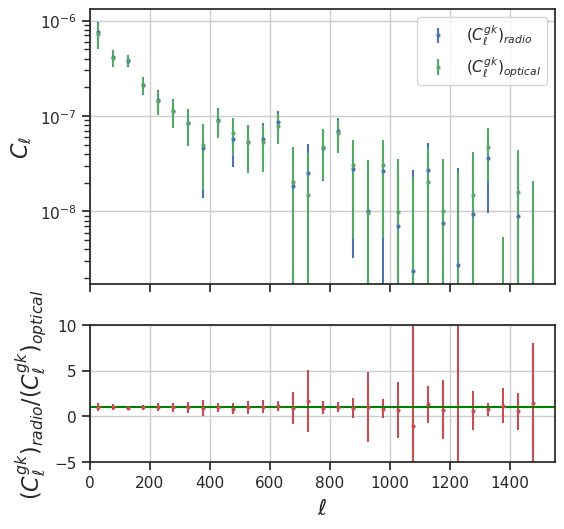

In [7]:
# C_gk comparison in optical field
plot_correlation_comparison(corr_srl_msk_opt, corr_opt_msk_opt, correlation_symbols=['gk', 'gk'], correlation_names=['radio', 'optical'], x_min=0, x_max=None, y_min=-5, y_max=10, x_scale='linear', y_scale='linear', title=None, with_error=True)

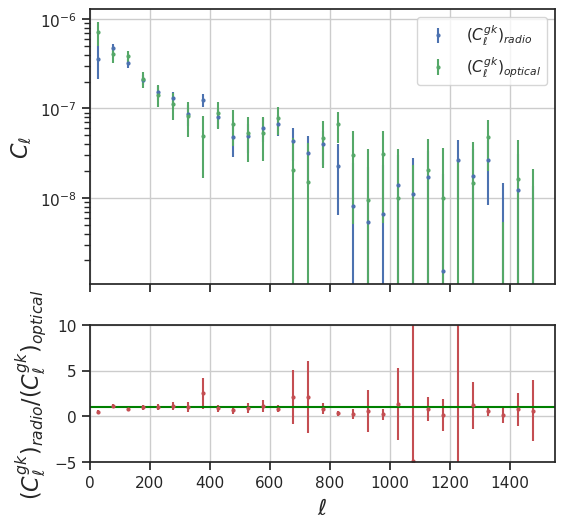

In [8]:
# C_gk comparison between optical and radio fields
plot_correlation_comparison(corr_srl_msk_inner, corr_opt_msk_opt, correlation_symbols=['gk', 'gk'], correlation_names=['radio', 'optical'], x_min=0, x_max=None, y_min=-5, y_max=10, x_scale='linear', y_scale='linear', title=None, with_error=True)

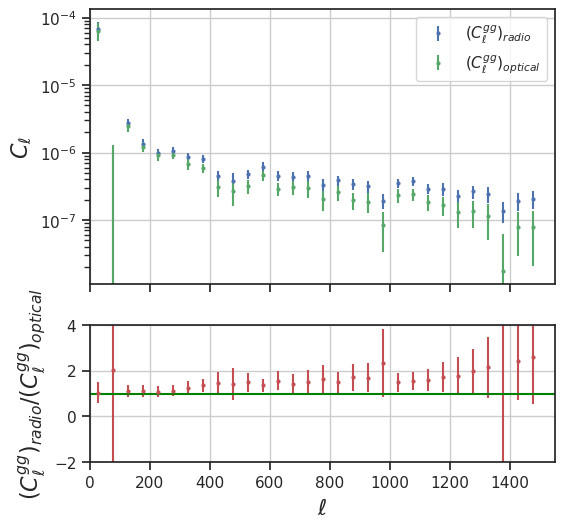

In [14]:
# C_gg comparison in optical field
plot_correlation_comparison(corr_srl_msk_opt, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'], x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', title=None, with_error=True, error_method='jackknife')

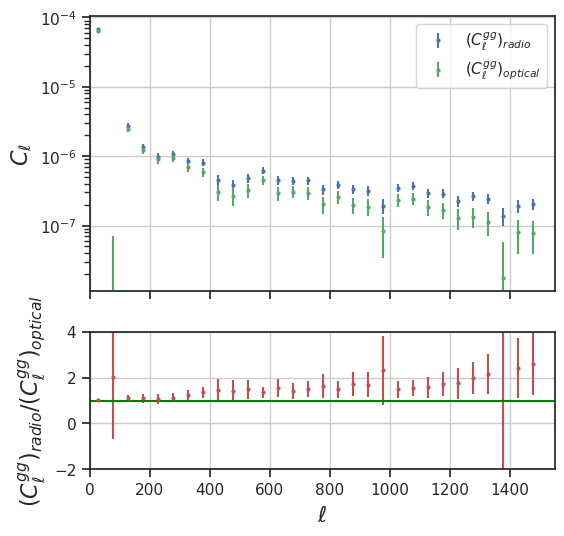

In [9]:
# C_gg comparison in optical field
plot_correlation_comparison(corr_srl_msk_opt, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'], x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', title=None, with_error=True)

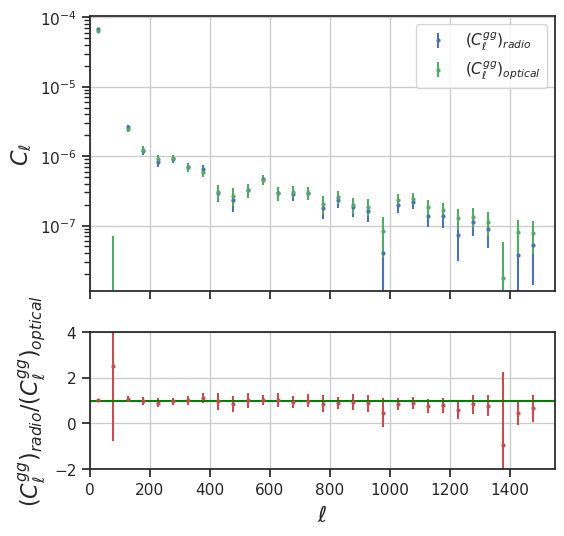

In [10]:
# C_gg comparison in optical field with correction for multicomponent shotnoise
plot_correlation_comparison(corr_srl_msk_opt_corrected, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'], x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', title=None, with_error=True)

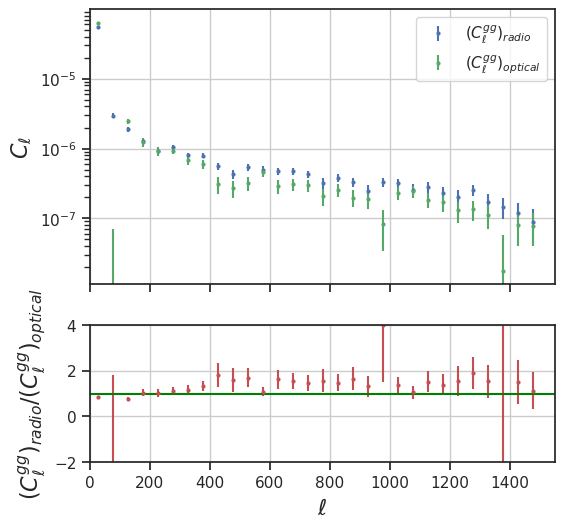

In [11]:
# C_gg raw in radio field vs optical in optical field
plot_correlation_comparison(corr_srl_msk_inner, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'], is_raw=[True, False], x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', title=None, with_error=True)

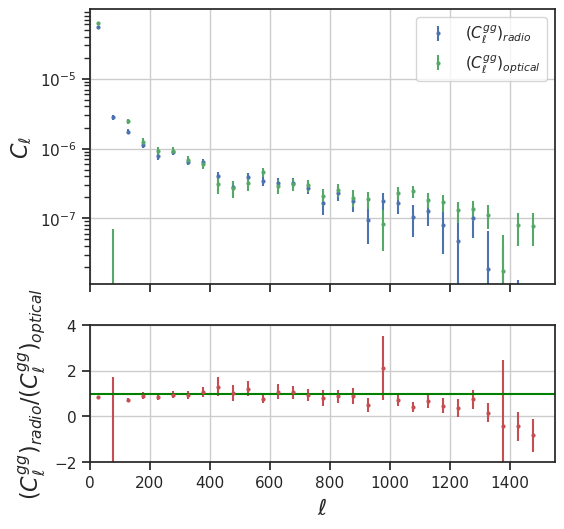

In [12]:
# C_gg fixed for multicomponent shotnoise in radio field vs optical in optical field
plot_correlation_comparison(corr_srl_msk_inner, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'], x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', title=None, with_error=True)

# Redshift distribution

## Comparison of dp / dz

In [5]:
# Redshift models
data_optical = get_lotss_data(data_release=2, flux_min_cut=None, optical=True, columns=['Total_flux', 'z_best'])
data_skads = get_skads_sim_data()

Original LoTSS DR2 datashape: (1819424, 93)


In [12]:
%reload_ext autoreload

In [13]:
redshift_distributions = get_redshift_distributions(data_optical, data_skads)
redshift_distributions = normalize_dists(redshift_distributions)

FileNotFoundError: [Errno 2] No such file or directory: '/home/snakoneczny/data/LoTSS/DR2/pz_deepfields/Pz_booterrors_wsum_deepfields_15mJy.fits'

In [104]:
# tomographer = pd.read_csv(os.path.join(DATA_PATH, 'LoTSS/tomographer/full_maskstrict_I2mJy_q5.csv'))
# redshift_distributions_bias['tomographer'][2] = {
#     'z': tomographer['z'][:-1],
#     'pz': tomographer['dNdz_b'][:-1],
#     'pz_min': tomographer['dNdz_b'][:-1] - tomographer['dNdz_b_err'][:-1] / 2,
#     'pz_max': tomographer['dNdz_b'][:-1] + tomographer['dNdz_b_err'][:-1] / 2,
# }
redshift_distributions_bias = scale_with_bias(redshift_distributions)

In [105]:
# Bias models
z_arr = redshift_distributions_bias['tomographer fit'][2]['z']
bias_arr = np.ones(len(z_arr))
with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
    cosmology_params = yaml.full_load(cosmology_file)['planck']
cosmology = ccl.Cosmology(**cosmology_params)
bias_arr = 1.5 * bias_arr / ccl.growth_factor(cosmology, 1. / (1. + np.array(z_arr)))

bias_models = {
    '1/D(z)': {'z': z_arr, 'b': bias_arr},
}

z_arr_tmp, n_arr_tmp = get_lotss_redshift_distribution(z_sfg=0.15, a=4.8, r=0.91, model='power_law', z_arr=redshift_distributions_bias['tomographer fit'][2]['z'])
bias_models['tomographer fit'] = {'z': redshift_distributions_bias['tomographer fit'][2]['z'], 'b': 1.5 * redshift_distributions_bias['tomographer fit'][2]['pz'] / n_arr_tmp}

/tmp/ipykernel_159629/1765629196.py:14: RuntimeWarning: invalid value encountered in true_divide
  bias_models['tomographer fit'] = {'z': redshift_distributions_bias['tomographer fit'][2]['z'], 'b': 1.5 * redshift_distributions_bias['tomographer fit'][2]['pz'] / n_arr_tmp}


In [106]:
# b g r c m y
styles_z = {
    'deep fields': 'b',
    'deep fields, boot': 'b--',
#     'power law AGN, to deep fields': 'r--',
    # 'power law AGN, DR2': 'r--',
    # 'z tail, DR1': 'g--',
    # 'photo-z, DR2': 'c',
    # 'SKADS': 'g',
    'tomographer fit': 'g',
    'TRECS': 'r',
}

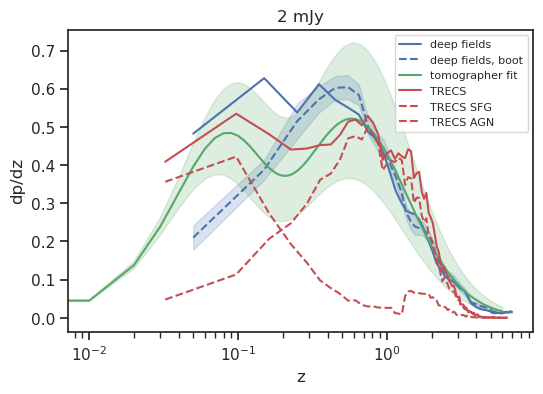

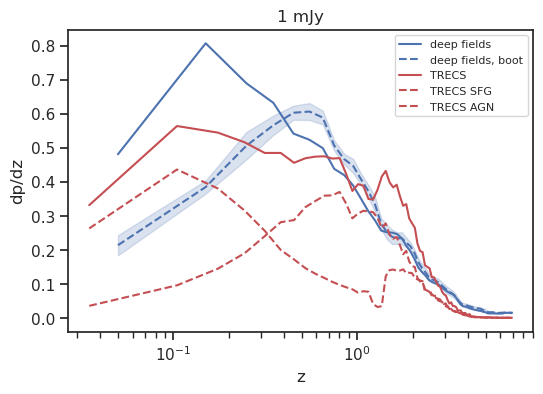

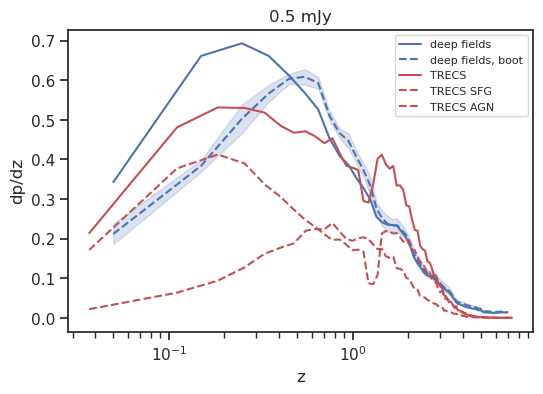

In [107]:
plot_redshift_distributions(redshift_distributions, styles_z, xscale='log', legend_size=8)

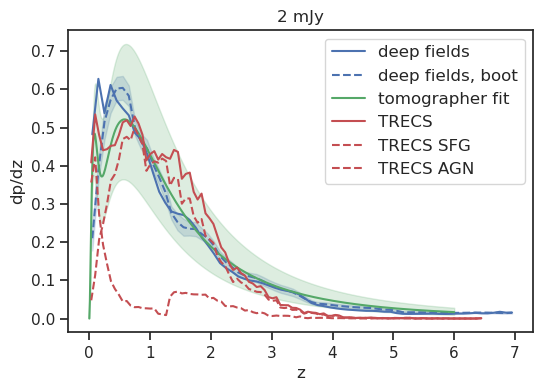

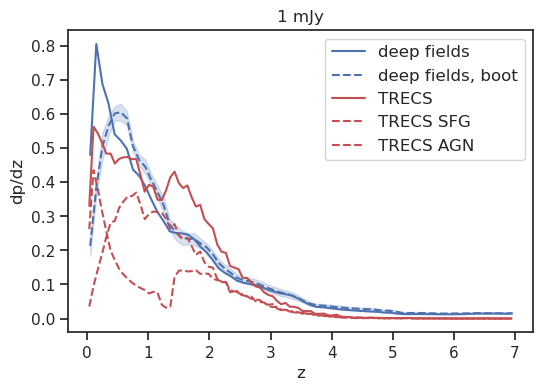

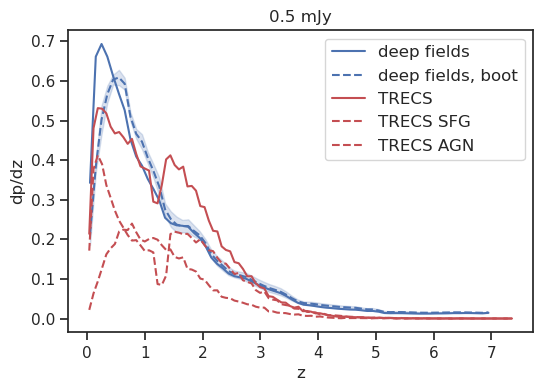

In [108]:
plot_redshift_distributions(redshift_distributions, styles_z, xscale='linear')

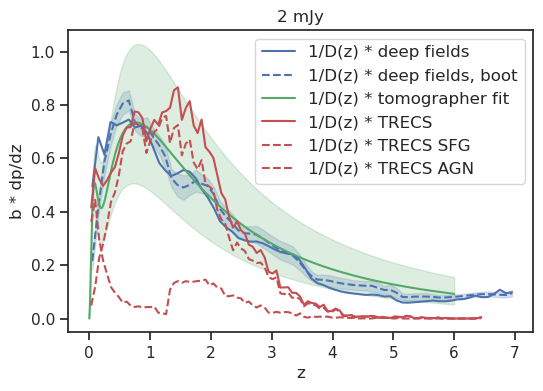

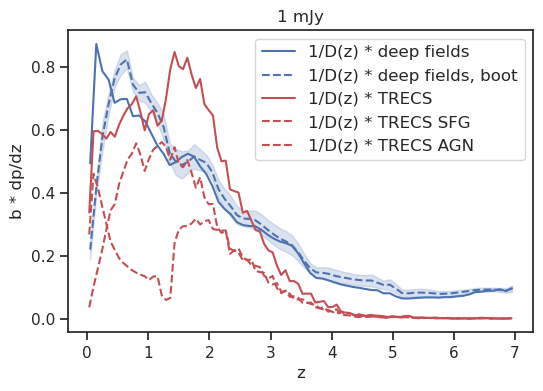

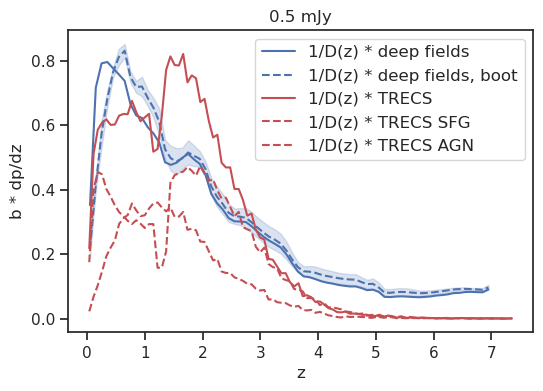

In [109]:
bias_scales = {
    'deep fields': (1, '1/D(z)'),
    'deep fields, boot': (1, '1/D(z)'),
    # 'power law AGN, DR2': (1, '1/D(z)'),
    # 'z tail, DR1': (1, '1/D(z)'),
    'tomographer fit': (1, '1/D(z)'),
    'TRECS': (1, '1/D(z)'),
}
plot_redshift_distributions(redshift_distributions_bias, styles_z, ylabel='b * dp/dz', bias_scales=bias_scales, xscale='linear')

In [110]:
for bias_name, bias_model in bias_models.items():
    y, _ = normalize_dist(bias_model['z'], bias_model['b'])
    plt.plot(bias_model['z'], bias_model['b'], label=bias_name)
    plt.xlim(left=0.05)
    plt.ylim(top=9)
    plt.legend()

NameError: name 'normalize_dist' is not defined

## Tomographer fits

In [19]:
z_sfg_0 = 0.13
a_0 = 4.66
r_0 = 0.94
p_0 = [z_sfg_0, a_0, r_0]

Best fit:  [3.67907719e-02 3.05458553e+00 1.65870250e-01 6.43650935e+02] [1.34397482e-02 1.90600942e-01 8.61068735e-02 6.79273898e+02]
Best fit with bias:  [3.54000092e-02 3.92648868e+00 1.71403269e-01 6.60371418e+02] [1.31260718e-02 1.88156053e-01 9.27054680e-02 7.25733679e+02]


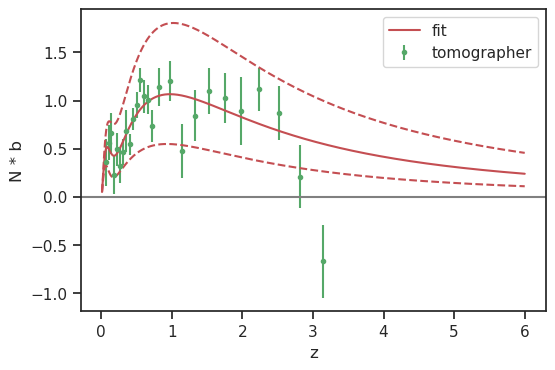

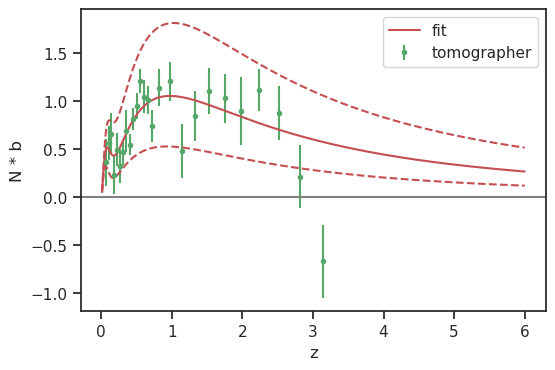

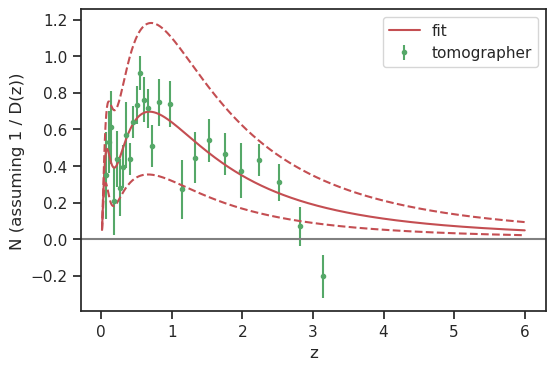

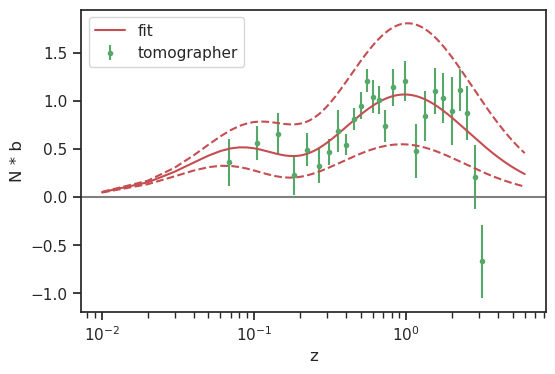

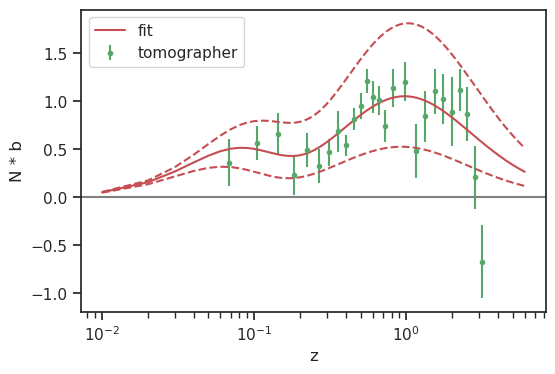

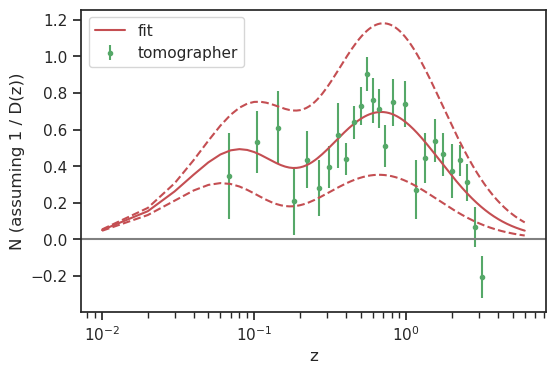

In [ ]:
# Overdensity map, 1.5 mJy, 7.5 SNR, inner mask
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/1.5mJy_7.5SNR_srl_overdensity_inner.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [50], p_0 + [30])

Best fit:  [3.86784639e-02 3.33051715e+00 1.81942793e-01 1.09298136e+05] [1.25595092e-02 2.39659868e-01 8.03138093e-02 9.88234681e+04]
Best fit with bias:  [3.72762721e-02 4.19951123e+00 1.88596699e-01 1.11252080e+05] [1.22415606e-02 2.36312992e-01 8.64939238e-02 1.04508957e+05]


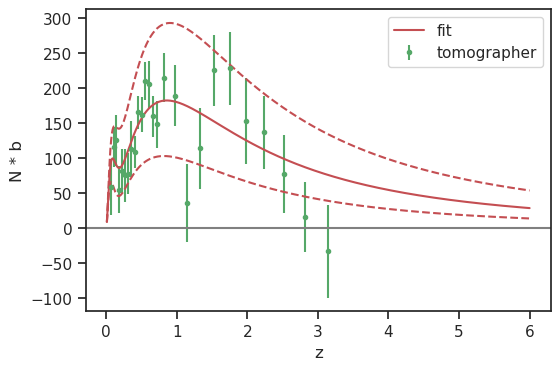

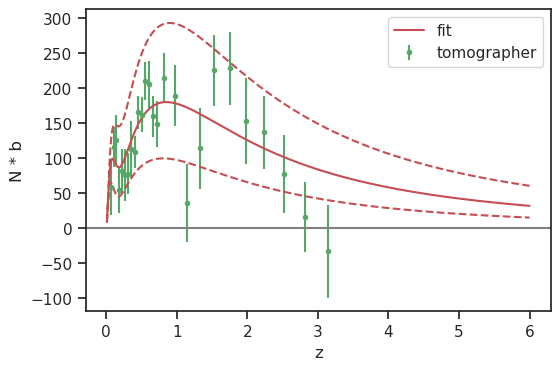

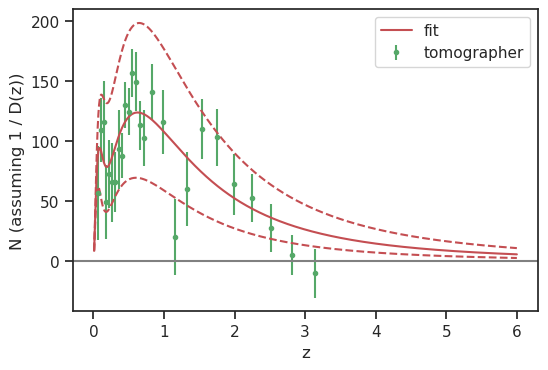

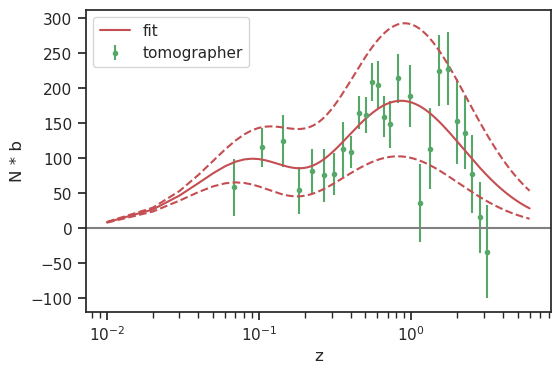

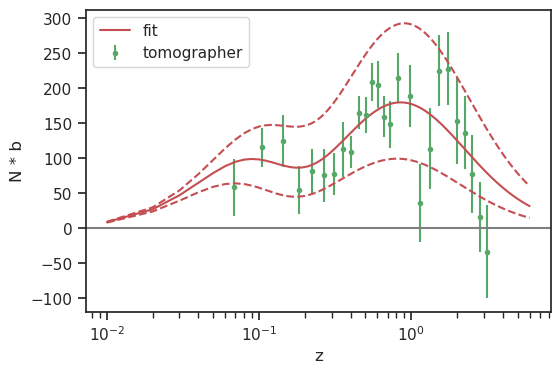

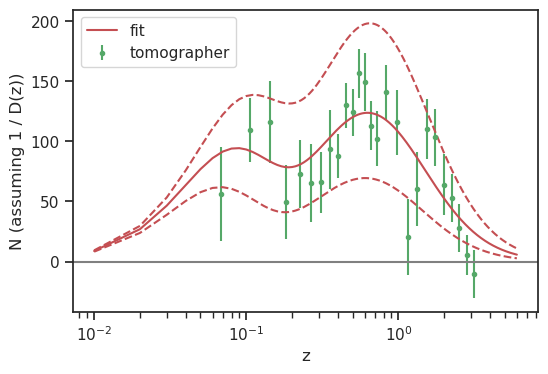

In [20]:
# Catalog, 1.5 mJy, 7.5 SNR, inner mask
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/1.5mJy_7.5SNR_srl_catalog_inner.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [10000], p_0 + [5000])

Best fit:  [3.48539959e-02 3.28642086e+00 1.56322618e-01 8.46433021e+02] [9.58155911e-03 2.09408724e-01 6.09845388e-02 6.73511403e+02]
Best fit with bias:  [3.36345841e-02 4.15214245e+00 1.61290857e-01 8.67622621e+02] [9.35244600e-03 2.06784619e-01 6.51949098e-02 7.14665072e+02]


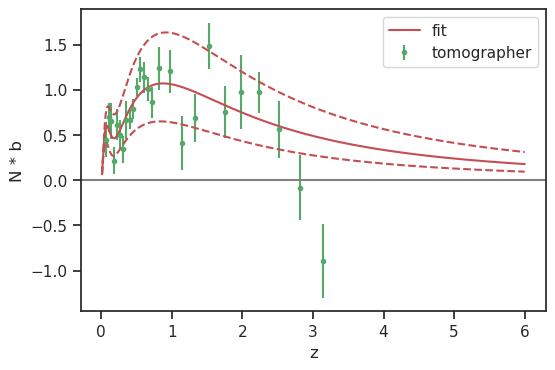

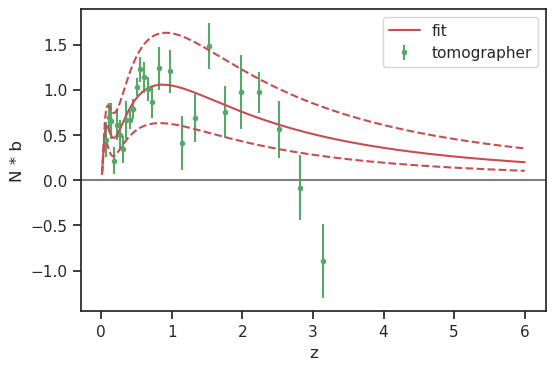

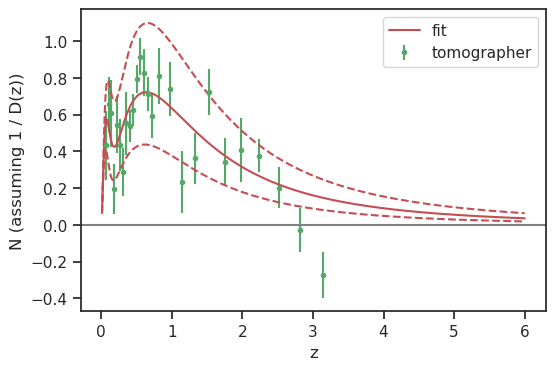

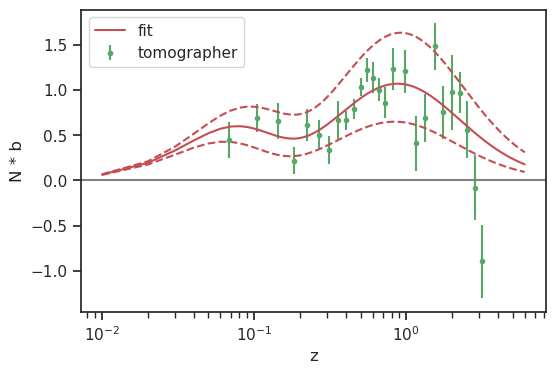

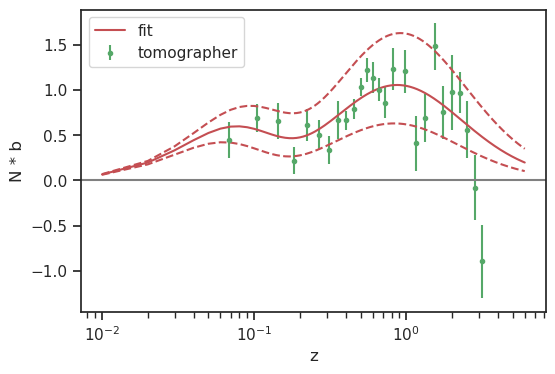

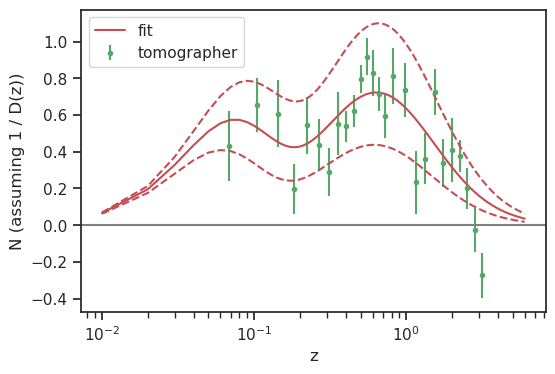

In [8]:
# Overdensity map, 2 mJy, 5 SNR
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/2mJy_5SNR_srl_overdensity_coverage.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [50], p_0 + [30])

Best fit:  [3.80332721e-02 3.48712202e+00 1.78327917e-01 1.05582608e+05] [1.03763390e-02 2.68111693e-01 6.49692199e-02 7.92758594e+04]
Best fit with bias:  [3.67232815e-02 4.35368050e+00 1.84729246e-01 1.07381574e+05] [1.00916653e-02 2.64741691e-01 6.96497138e-02 8.34411543e+04]


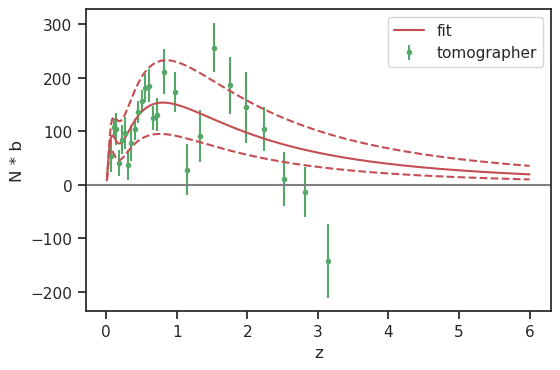

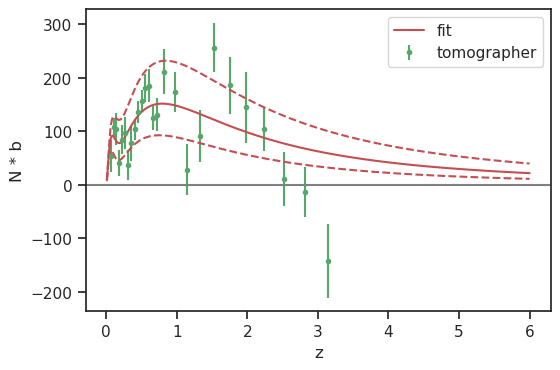

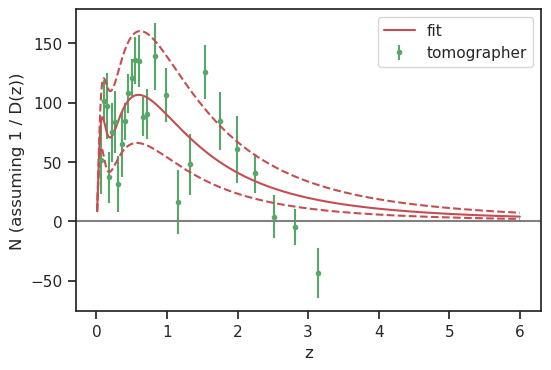

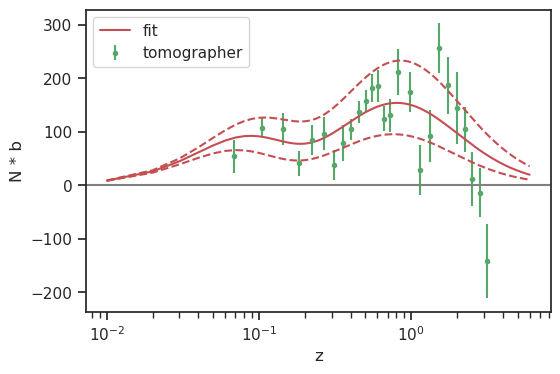

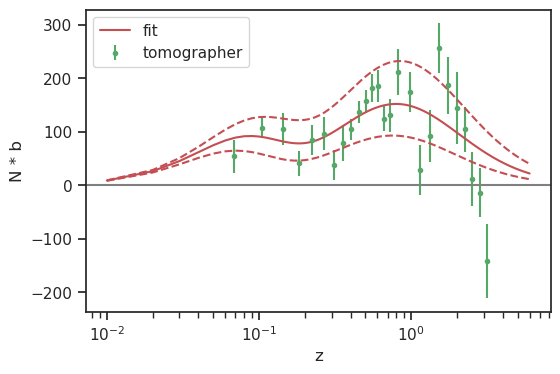

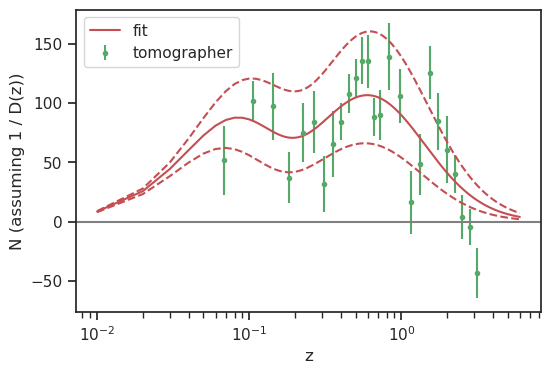

In [9]:
# Catalog, 2 mJy, 5 SNR
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/2mJy_5SNR_srl_catalog_coverage.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [10000], p_0 + [5000])

## Parametrization

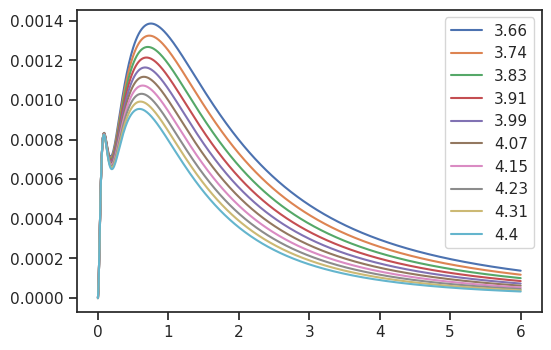

In [18]:
z_sfg = 0.037
a = 4.070
r = 0.183

scale = 0.1
n_lines = 10
for a in np.arange(a * (1 - scale), a * (1 + scale), a * scale / n_lines * 2):
    z_arr, n_arr = get_lotss_redshift_distribution(z_sfg=z_sfg, a=a, r=r, model='power_law', z_max=6, normalize=False)
    plt.plot(z_arr, n_arr, label=np.round(a, 2))
plt.legend()
plt.show()

## Flux cuts on photo-z

In [19]:
data = get_lotss_data(data_release=2, flux_min_cut=None, optical=True)

../data_lotss.py:260: TableReplaceWarning: converted column 'release' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'brickid' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'objid' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'maskbits' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'flag_qual' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'zwarning_sdss' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'plate_sdss' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'mjd_s

Original LoTSS DR2 datashape: (1819424, 93)


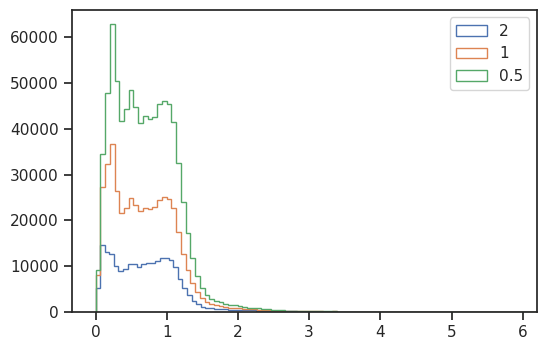

In [25]:
# DR2
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=False)
plt.xlim(right=6.2)
plt.legend()

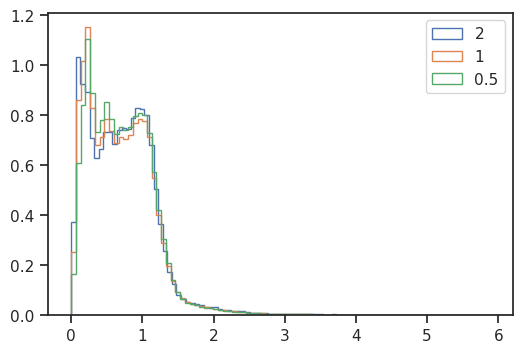

In [26]:
# DR2
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=True)
plt.xlim(right=6.2)
plt.legend()

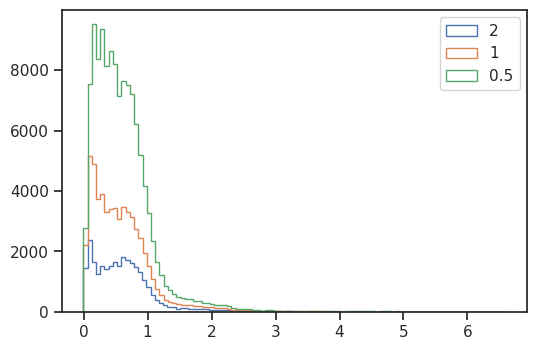

In [11]:
# DR1
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=False)
plt.legend()

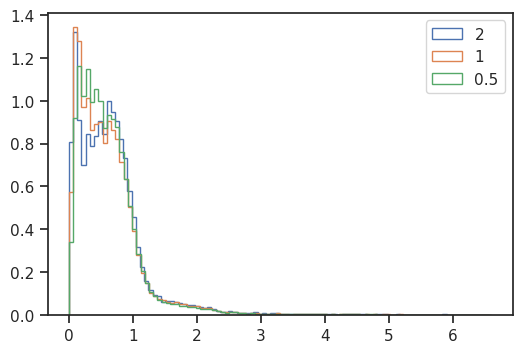

In [29]:
# DR1
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=True)
plt.legend()

# Maps

## Jackknife

In [16]:
masks = get_jackknife_masks(experiment.masks['g'], LOTSS_JACKKNIFE_REGIONS, nside=512)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
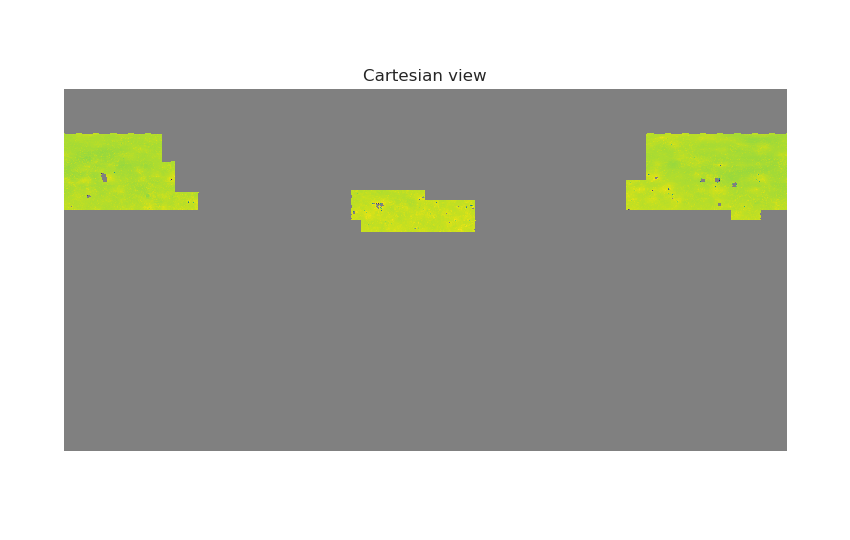

In [9]:
%matplotlib widget
hp.visufunc.cartview(map=masks[2], xsize=1000, badcolor='gray', bgcolor='white', cbar=False, norm=None,cmap='viridis')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
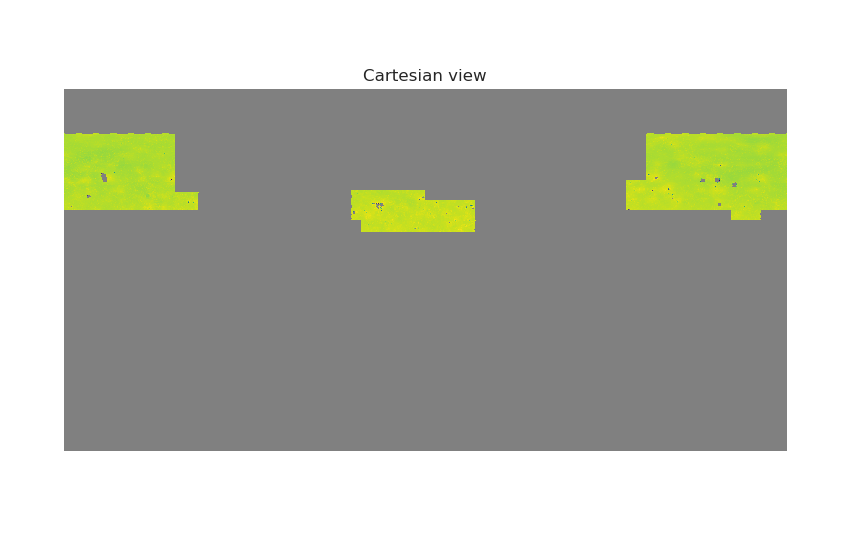

In [10]:
%matplotlib widget
hp.visufunc.cartview(map=experiment.masks['g'], xsize=1000, badcolor='gray', bgcolor='white', cbar=False, norm=None,cmap='viridis')

In [17]:
# Possibilities: (8, 4) 32 in total, (4, 2) 16 in total
regions = [
    {'lon': (100, -113 + 360, 11), 'lat': (25, 68, 4)},
    {'lon': (-37, 25, 5), 'lat': (19, 40, 2)},
]

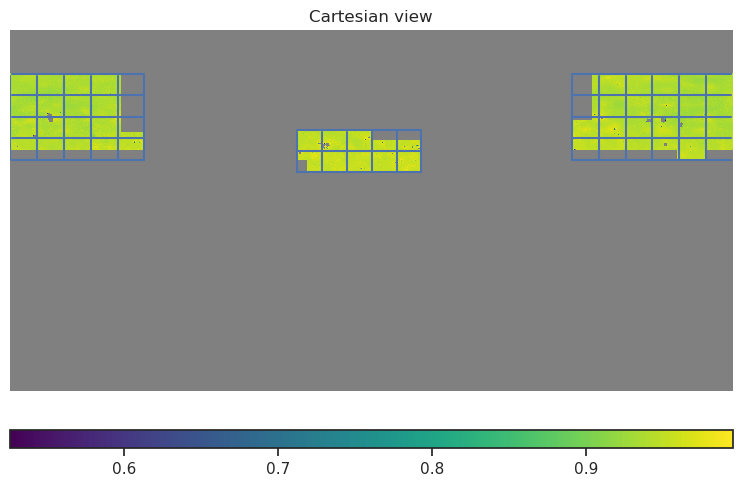

In [21]:
plot_jackknife_regions(experiment, regions)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
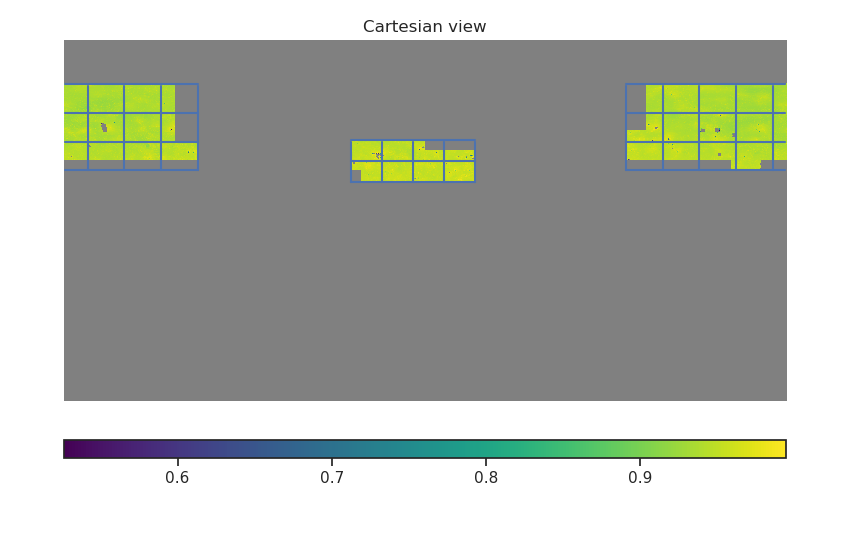

In [12]:
%matplotlib widget
plot_jackknife_regions(experiment, regions)

## Subregions

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globa

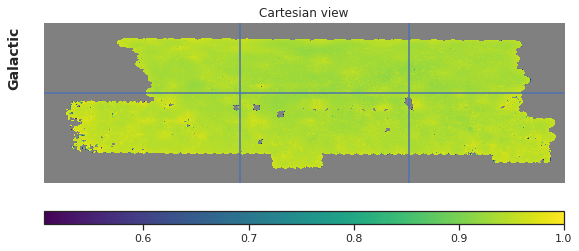

In [7]:
%matplotlib inline
hp.visufunc.cartview(map=experiment.masks['g'], xsize=1000, lonra=[105, -70], latra=[18, 75], badcolor='gray', bgcolor='white', cbar=False, coord='G', norm=None, cmap='viridis')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
fig.colorbar(image, orientation='horizontal', aspect=40, pad=0.08, ax=ax)

lat_arr = [50]
lon_arr = [-160, -220]
for lat in lat_arr:
    lon_range = np.arange(-360, 0, 1)
    plt.plot(lon_range, [lat] * len(lon_range), 'b')
for lon in lon_arr:
    lat_range = np.arange(-90, 90, 1)
    plt.plot([lon] * len(lat_range), lat_range, 'b')

plt.show()

## Interactive

28/03/2022 13:47:56 WARNING: 0.0 180.0 -180.0 180.0
28/03/2022 13:47:56 INFO: The interval between parallels is 30 deg -0.00'.
28/03/2022 13:47:56 INFO: The interval between meridians is 30 deg -0.00'.
28/03/2022 13:47:56 WARNING: 82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
28/03/2022 13:47:56 INFO: The interval between parallels is 1 deg 0.00'.
28/03/2022 13:47:56 INFO: The interval between meridians is 1 deg 0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
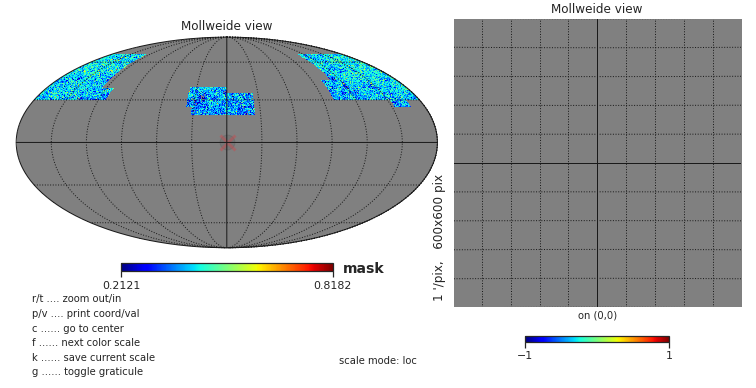

In [9]:
%matplotlib widget
my_mollview(experiment.masks['g'], unit='mask', fwhm=0, zoom=True)

16/03/2022 13:40:23 INFO: Sigma is 5.095931 arcmin (0.001482 rad) 
16/03/2022 13:40:23 INFO: -> fwhm is 12.000000 arcmin
16/03/2022 13:40:23 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
16/03/2022 13:40:23 INFO: -> fwhm is 0.000000 arcmin
16/03/2022 13:40:23 WARNING: 0.0 180.0 -180.0 180.0
16/03/2022 13:40:23 INFO: The interval between parallels is 30 deg -0.00'.
16/03/2022 13:40:23 INFO: The interval between meridians is 30 deg -0.00'.
16/03/2022 13:40:23 WARNING: 82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
16/03/2022 13:40:23 INFO: The interval between parallels is 1 deg 0.00'.
16/03/2022 13:40:23 INFO: The interval between meridians is 1 deg 0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
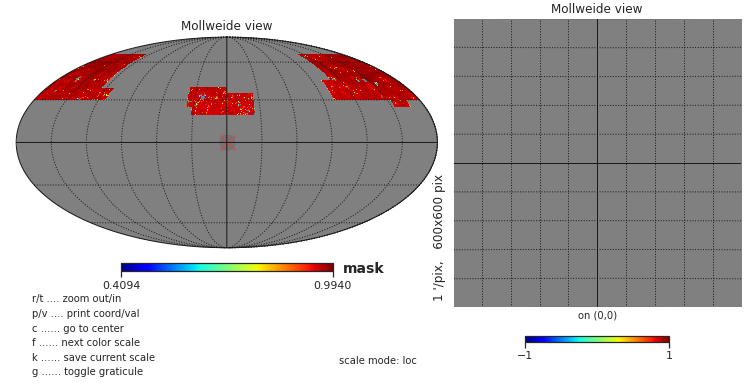

In [73]:
%matplotlib widget
my_mollview(experiment.masks['g'], unit='mask', fwhm=0.2, zoom=True)

09/02/2022 15:47:02 INFO: Sigma is 12.739827 arcmin (0.003706 rad) 
09/02/2022 15:47:02 INFO: -> fwhm is 30.000000 arcmin
09/02/2022 15:47:02 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
09/02/2022 15:47:02 INFO: -> fwhm is 0.000000 arcmin
09/02/2022 15:47:02 WARNING: 0.0 180.0 -180.0 180.0
09/02/2022 15:47:02 INFO: The interval between parallels is 30 deg -0.00'.
09/02/2022 15:47:02 INFO: The interval between meridians is 30 deg -0.00'.
09/02/2022 15:47:02 WARNING: 82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
09/02/2022 15:47:02 INFO: The interval between parallels is 1 deg 0.00'.
09/02/2022 15:47:02 INFO: The interval between meridians is 1 deg 0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
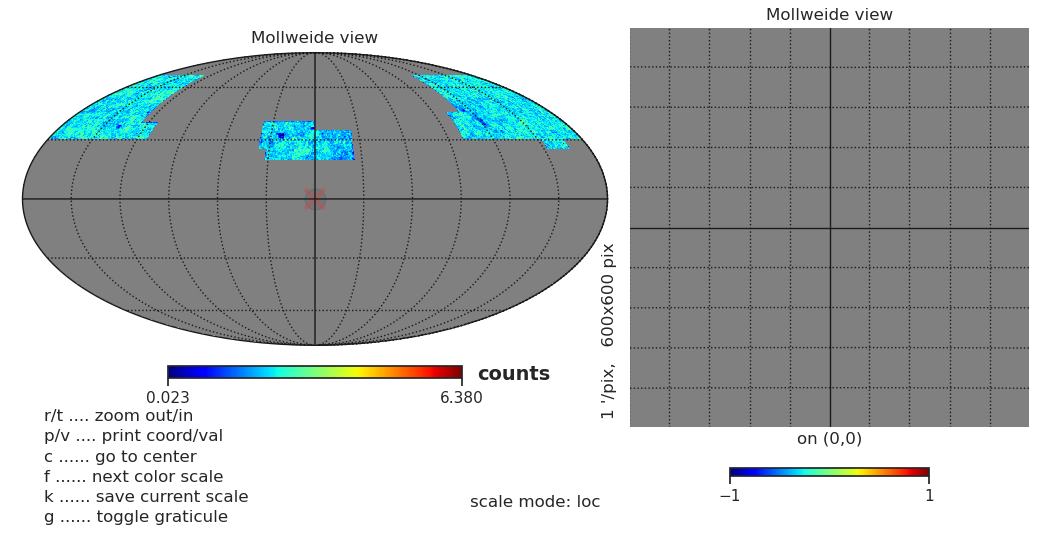

In [28]:
%matplotlib widget
my_mollview(experiment.base_maps['g'], unit='counts', fwhm=0.5, zoom=True)

09/02/2022 15:45:45 INFO: Sigma is 20.383723 arcmin (0.005929 rad) 
09/02/2022 15:45:45 INFO: -> fwhm is 48.000000 arcmin
09/02/2022 15:45:45 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
09/02/2022 15:45:45 INFO: -> fwhm is 0.000000 arcmin
09/02/2022 15:45:45 WARNING: 0.0 180.0 -180.0 180.0
09/02/2022 15:45:45 INFO: The interval between parallels is 30 deg -0.00'.
09/02/2022 15:45:46 INFO: The interval between meridians is 30 deg -0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
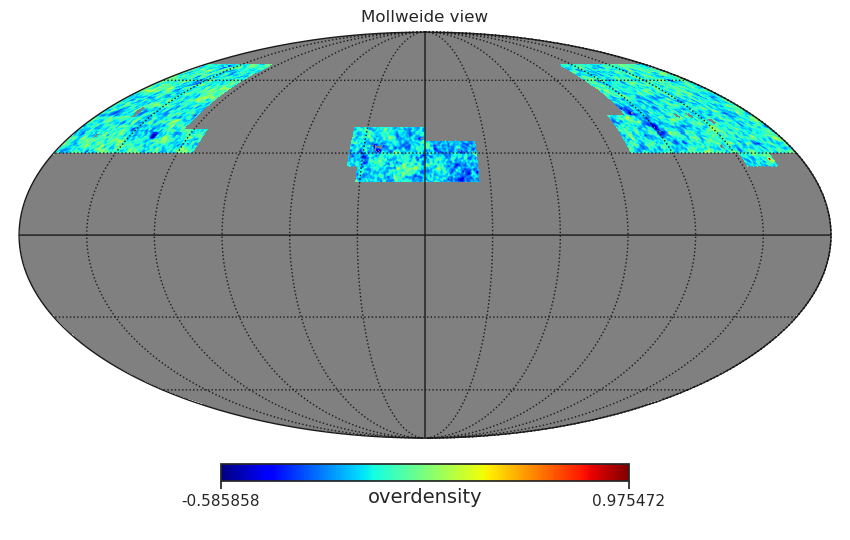

In [20]:
%matplotlib widget
my_mollview(experiment.processed_maps['g'], unit='overdensity', fwhm=0.8)

## Non interactive

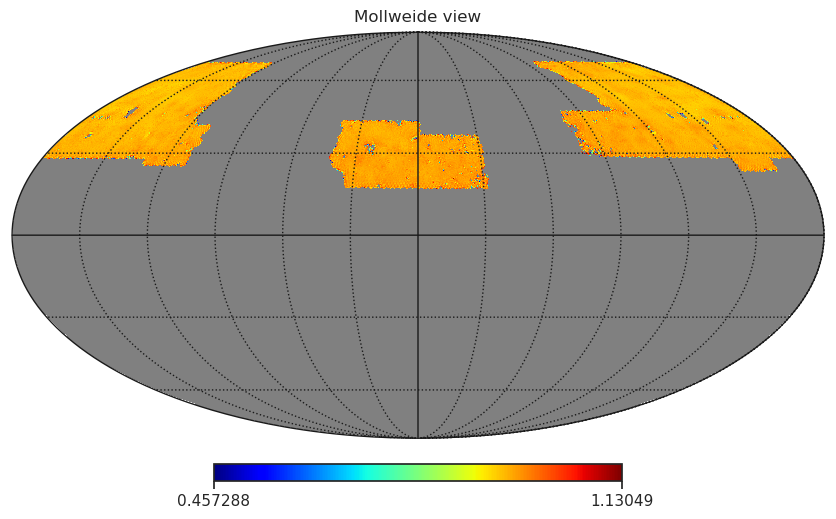

In [18]:
my_mollview(experiment.masks['g'], unit='', fwhm=0.002)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 40.767446 arcmin (0.011859 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 96.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


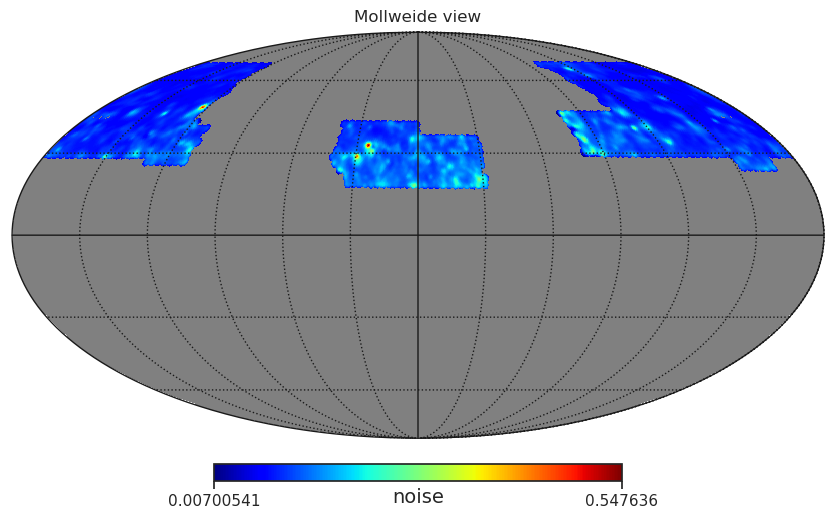

In [13]:
my_mollview(experiment.noise_maps['g'], unit='noise', fwhm=1.6)

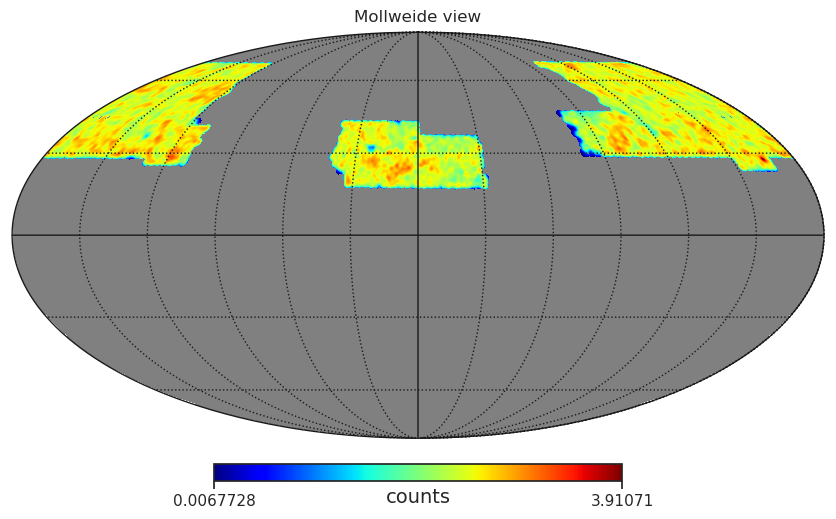

In [14]:
my_mollview(experiment.base_maps['g'], unit='counts', fwhm=1.4)

In [9]:
my_mollview(experiment.processed_maps['t'], unit='mK', fwhm=1.2)

KeyError: 't'

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 15.287792 arcmin (0.004447 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 36.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


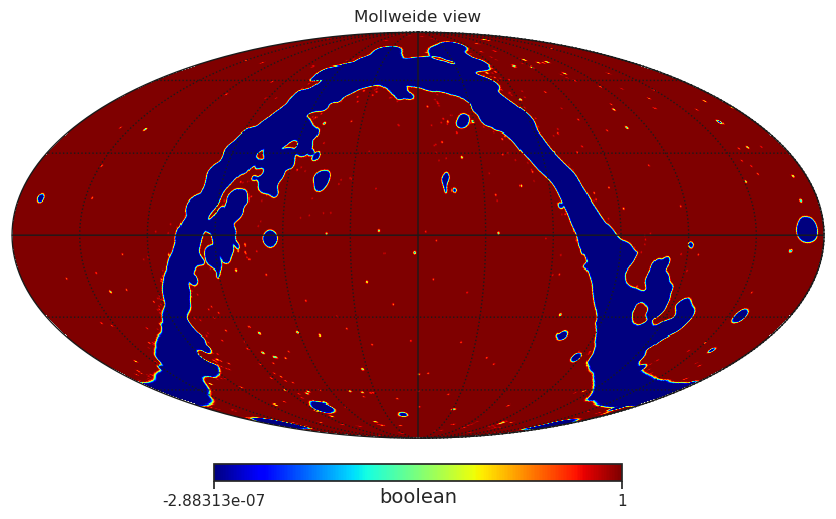

In [11]:
my_mollview(experiment.masks['t'], unit='boolean', fwhm=0.6)

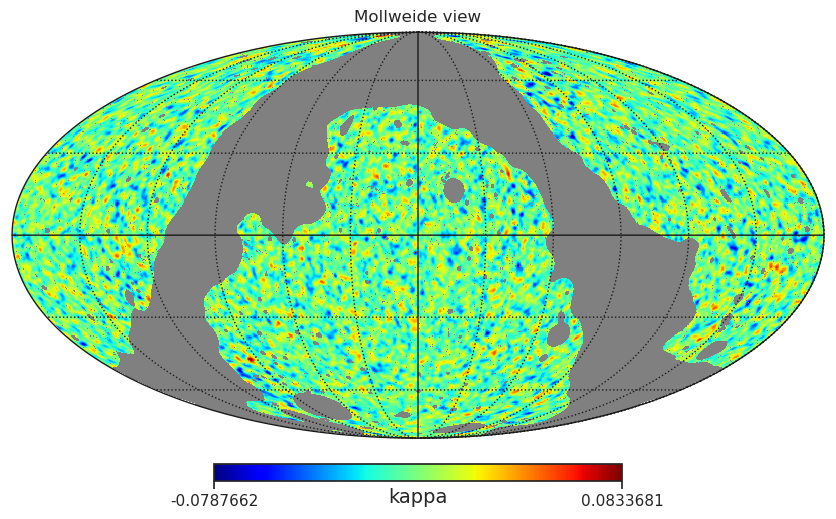

In [15]:
my_mollview(experiment.processed_maps['k'], unit='kappa', fwhm=1.6)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 20.383723 arcmin (0.005929 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 48.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


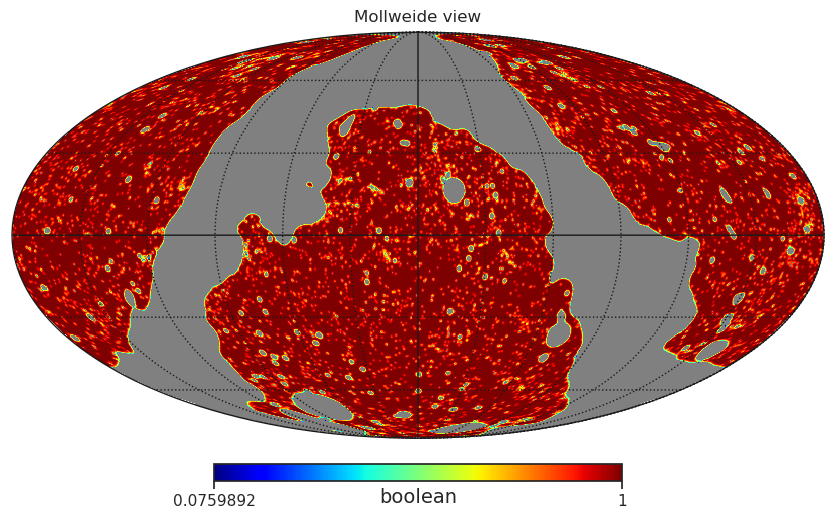

In [16]:
my_mollview(experiment.masks['k'], unit='boolean', fwhm=0.8)